## ASSIGNMENT - 1

In [5]:
# Import necessary Libraries
import os
import cv2 as cv
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil
import numpy as np
from scipy import linalg
from torchvision.models import inception_v3, resnet18
import pandas as pd
import matplotlib.pyplot as plt
import re
from torch.utils.data import random_split
from sklearn.metrics import f1_score
import copy
from torch.optim import lr_scheduler
from torchvision import models

data_loc = '/home/kawada-kuka/siddharth/ADRL/data_aug'

ModuleNotFoundError: No module named 'pandas'

##### Data Preparation and Augmentation

In [ ]:
# Resizing the images to 128*128
subfolders = [f.path for f in os.scandir(data_loc) if f.is_dir()]
c = 1
for folder in subfolders:
    
    for filename in os.listdir(folder):
        c+=1
        img = cv.imread(os.path.join(folder, filename))
        if img.shape != (128, 128, 3):
            print('Resizing image: ', os.path.join(folder, filename))
            img = cv.resize(img, (128, 128))
            cv.imwrite(os.path.join(folder, filename), img)
            print("Resized shape is: ", img.shape)
        
print("total_datapoints===>",c)

In [ ]:
# Function to flip images
def copy_folders_and_flip_images(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    
    shutil.copytree(src_dir, dest_dir)
    
    for root, dirs, files in os.walk(dest_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:    
                    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
                    file_name, ext = os.path.splitext(file)
                    flipped_file_path = os.path.join(root, f"{file_name}_flipped{ext}")
                    flipped_img.save(flipped_file_path)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")


In [ ]:
source_directory = "/home/kawada-kuka/siddharth/ADRL/data/animals"
destination_directory = "/home/kawada-kuka/siddharth/ADRL/data_aug"

copy_folders_and_flip_images(source_directory, destination_directory)

##### Animal_Dataset Class


In [2]:
class AnimalsDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
        self.data = []
        self.label_map = {}
        for i, folder in enumerate(self.subfolders):
            for filename in os.listdir(folder):
                image_path = os.path.join(folder, filename)
                label_name = folder.split('/')[-1]
                self.label_map[label_name] = i
                self.data.append((image_path,i))          
        random.shuffle(self.data)
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, img):
        img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        return img_transform(img)
    
    def __getitem__(self, idx):
        if isinstance(idx, int):  
            img = cv.imread(self.data[idx][0])  
            label = self.data[idx][1] 
            img = self.transform(img)  
            return img, label
        
        elif isinstance(idx, slice):  
            indices = range(*idx.indices(len(self.data)))
            batch_imgs = []
            batch_labels = []
            for i in indices:
                img = cv.imread(self.data[i][0])  
                img = self.transform(img)  
                batch_imgs.append(img)
                batch_labels.append(self.data[i][1])
            return torch.stack(batch_imgs), batch_labels

        elif isinstance(idx, list):  
            batch_imgs = []
            batch_labels = []
            for i in idx:
                img = cv.imread(self.data[i][0])  
                img = self.transform(img)  
                batch_imgs.append(img)
                batch_labels.append(self.data[i][0])
            
            # Return batch of images and labels
            return torch.stack(batch_imgs), batch_labels


In [3]:
sample_dataset = AnimalsDataset(data_loc)
sample_dataset[0:10][0].shape

torch.Size([10, 3, 128, 128])

In [4]:
sample_dataset.label_map

{'duck': 0,
 'parrot': 1,
 'fly': 2,
 'chimpanzee': 3,
 'hyena': 4,
 'possum': 5,
 'bear': 6,
 'oyster': 7,
 'kangaroo': 8,
 'horse': 9,
 'lobster': 10,
 'owl': 11,
 'starfish': 12,
 'fox': 13,
 'cat': 14,
 'porcupine': 15,
 'bat': 16,
 'goat': 17,
 'donkey': 18,
 'coyote': 19,
 'antelope': 20,
 'orangutan': 21,
 'flamingo': 22,
 'pigeon': 23,
 'ox': 24,
 'leopard': 25,
 'koala': 26,
 'ladybugs': 27,
 'woodpecker': 28,
 'dragonfly': 29,
 'boar': 30,
 'crab': 31,
 'zebra': 32,
 'wombat': 33,
 'pig': 34,
 'hedgehog': 35,
 'mosquito': 36,
 'goose': 37,
 'turkey': 38,
 'mouse': 39,
 'gorilla': 40,
 'snake': 41,
 'raccoon': 42,
 'whale': 43,
 'badger': 44,
 'pelecaniformes': 45,
 'turtle': 46,
 'rat': 47,
 'dolphin': 48,
 'shark': 49,
 'seahorse': 50,
 'reindeer': 51,
 'butterfly': 52,
 'bison': 53,
 'hare': 54,
 'lizard': 55,
 'panda': 56,
 'grasshopper': 57,
 'sheep': 58,
 'hamster': 59,
 'goldfish': 60,
 'deer': 61,
 'squid': 62,
 'otter': 63,
 'beetle': 64,
 'seal': 65,
 'rhinoceros': 6

#### Q1 . DCGAN

The Generator architecture is a 6 layer transpose convolutional neural network that upsamples the image in each layer  
The Discriminator architecture is a 6 layer convolutional neural network architecture that downsamples in each layer to finally obtain a single dimensional output on which sigmoid is applied for binary classification



In [5]:
class Model(nn.Module):
    def __init__(self, feature_maps_g, latent_dim, img_channels, feature_maps_d):
        super(Model, self).__init__()
      
        self.generator = Generator(feature_maps=feature_maps_g, latent_dim=latent_dim, img_channels=img_channels)
        self.discriminator = Discriminator(img_channels=img_channels, feature_maps=feature_maps_d)
    
    def generate(self, z):
        return self.generator(z)

    def discriminate(self, images):
        return self.discriminator(images)

#Architecture for Generator
class Generator(nn.Module):
    def __init__(self, feature_maps=1024, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        # self.fc1 = nn.Linear(100, 100)
        # self.leaky_relu = nn.LeakyReLU(0.2)
        self.generator = nn.Sequential(
            # First layer 
            nn.ConvTranspose2d(latent_dim, feature_maps, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # Second layer
            nn.ConvTranspose2d(feature_maps, feature_maps // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 2),
            nn.ReLU(True),

            # Third layer
            nn.ConvTranspose2d(feature_maps // 2, feature_maps // 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 4),
            nn.ReLU(True),

            # Fourth layer
            nn.ConvTranspose2d(feature_maps // 4, feature_maps // 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 8),
            nn.ReLU(True),

            # Fifth layer
            nn.ConvTranspose2d(feature_maps // 8, feature_maps // 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 16),
            nn.ReLU(True),

            # Sixth layer
            nn.ConvTranspose2d(feature_maps // 16, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Tanh activation for image output in range [-1, 1]
        )
    
    def forward(self, x):
        # x = self.fc1(x)
        # x = self.leaky_relu(x)
        x = x.view(x.size(0), -1, 1, 1)  # Reshape the latent vector into (batch_size, latent_dim, 1, 1)
        return self.generator(x)
    
    
#Architecture for Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_maps=64):
        super(Discriminator, self).__init__()
 
        self.discriminator = nn.Sequential(
            # Layer 1
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), 
 
            # Layer 2
            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 3
            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 4
            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 5
            nn.Conv2d(feature_maps * 8, feature_maps * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 16),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 6
            nn.Conv2d(feature_maps * 16, 1, kernel_size=4, stride=1, padding=0, bias=False),
 
            #Output: Single value (real/fake), flatten to 1x1
            nn.Flatten(),
            nn.Sigmoid()
            # Output is a probability (real or fake)
        )
 
    def forward(self, x):
        x = self.discriminator(x)
        x = x.view(-1,1).squeeze(1)
        return x

In [6]:
# gen = Generator()
# z = torch.randn(32,100)
# img = gen(z)
# img.shape

In [7]:
# dis = Discriminator()
# imgs = sample_dataset[0:10][0]
# dis(imgs).shape

##### Training Loop

In [8]:
def train_model(data_loader, model, latent_dim, device, num_epochs=100, k=1, learning_rate=0.001):
    # Optimizers
    optimizer_G = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(model.discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Path to the loss file
    loss_path = '/home/kawada-kuka/siddharth/ADRL/Losses/DCGAN/DCGAN1.txt'

    # Check if the loss log file exists; if not, create it and add a header
    if not os.path.exists(loss_path):
        with open(loss_path, 'w') as loss_log_file:
            loss_log_file.write("Epoch, d_loss, g_loss\n")  # Write the header if the file doesn't exist
         

    for epoch in range(num_epochs):
        datapoints = 0
        total_gen_loss = 0
        total_disc_loss = 0

        # Use tqdm to show the progress bar with loss updates
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

        for i, (real_images, _) in progress_bar:
            real_images = real_images.to(device)

            # Train Discriminator k times
            for _ in range(k):
                optimizer_D.zero_grad()

                # Discriminator on real images
                real_preds = model.discriminate(real_images)
                d_loss_real = criterion(real_preds, torch.ones_like(real_preds))

                # Discriminator on fake images
                z = torch.randn(real_images.size(0), latent_dim).to(device)  # Latent vector
                fake_images = model.generate(z)

                fake_preds = model.discriminate(fake_images.detach())
                d_loss_fake = criterion(fake_preds, torch.zeros_like(fake_preds))  # Label for fake should be zeros

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_D.step()

            # Train Generator once
            optimizer_G.zero_grad()

            z = torch.randn(real_images.size(0), latent_dim).to(device)  # Latent vector
            fake_images = model.generate(z)
            fake_preds = model.discriminate(fake_images)

            g_loss = criterion(fake_preds, torch.ones_like(fake_preds))  # Generator wants to fool the discriminator
            g_loss.backward()
            optimizer_G.step()

            total_disc_loss += d_loss.item()
            total_gen_loss += g_loss.item()

            datapoints += real_images.size(0)
            avg_disc_loss = total_disc_loss / datapoints
            avg_gen_loss = total_gen_loss / datapoints

            # Update tqdm description to include current losses
            progress_bar.set_postfix({
                'd_loss': f'{avg_disc_loss:.4f}',
                'g_loss': f'{avg_gen_loss:.4f}'
            })

        print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {avg_disc_loss:.4f}, g_loss: {avg_gen_loss:.4f}')
        
        
        with open(loss_path, 'a') as loss_log_file:
            loss_log_file.write(f'{epoch + 1}, {avg_disc_loss:.4f}, {avg_gen_loss:.4f}\n')
            loss_log_file.flush()  # Force the data to be written to the file
        
        if epoch>300:
            # Create a folder named after the epoch number
            folder_name = f'/home/kawada-kuka/siddharth/ADRL/models/DCGAN_1/epoch_{epoch+1}'
            os.makedirs(folder_name, exist_ok=True)

            # Save the generator and discriminator models in the folder
            torch.save(model.generator, os.path.join(folder_name, 'generator_best.pth'))
            torch.save(model.discriminator, os.path.join(folder_name, 'discriminator_best.pth'))

We fixed the following hyperparameters during our experimentation (As per standard practices):   
Latent dimension of input random variable (z) = 100   
No. of epochs = 2000  
Batch size = 64  
No. of feature maps in first layer of generator = 1024  
No. of feature maps in first layer of discriminator = 64  
Starting learning rate = 0.0002  
  
The following hyperparameters were varied and the results were documented :  
k (No of times discriminator is trained for one training of generator) -> 1, 2   
Adding a linear layer before the generator for feature extraction on the input random variable (yes/no)  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
img_channels = 3
feature_maps_g = 1024
feature_maps_d = 64
batch_size = 64
learning_rate = 0.0002
num_epochs = 2000
k = 1

# Initialize model
model = Model(feature_maps_g=feature_maps_g, latent_dim=latent_dim, img_channels=img_channels, feature_maps_d=feature_maps_d)
model.to(device)

# DataLoader
data_loader = DataLoader(AnimalsDataset(data_loc), batch_size=batch_size, shuffle=True)

# Call the training function
train_model(data_loader, model, latent_dim, device, num_epochs=num_epochs, k=k, learning_rate=learning_rate)

#### Q2 10*10 grid of images

Here we have plotted the result as a 10x10 grid image of the best model that we have saved so far during training. As a general rule, we have saved every model after epoch 300 for all the hyperparameter cases that we have discussed above. The best model was given for the case where k=1 at epoch 593 for no linear feature extraction layer before the generator.  
  
Note that the notion of 'best' is entirely subjective as it is decided through the visual perception and coherence of the images by human judgement.  

/tmp/ipykernel_23338/2415235239.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(model_path).to('cpu')


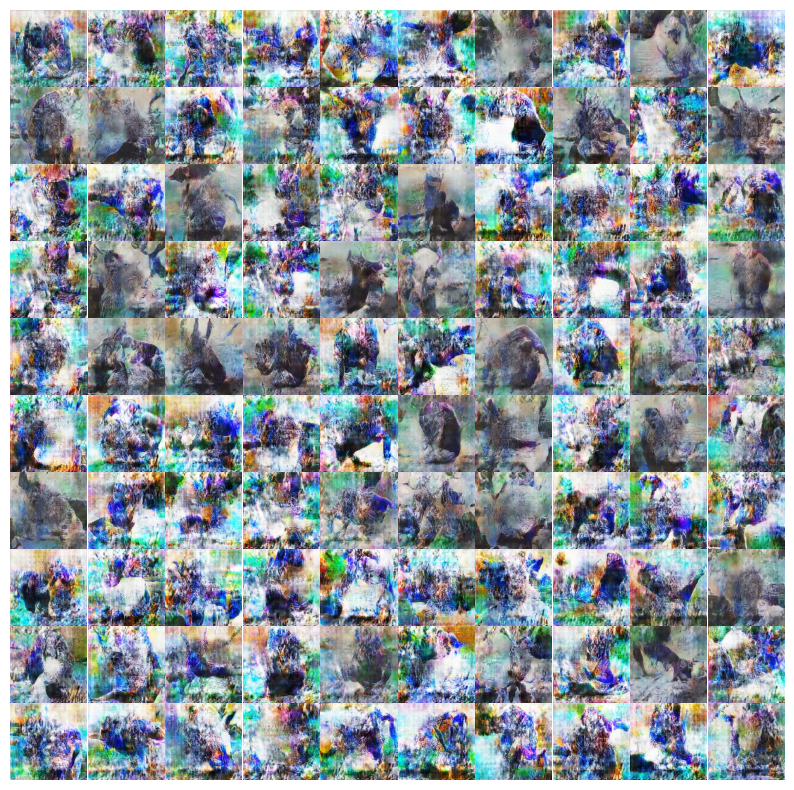

In [8]:
# Images of best model 
def plot_img_dcgan(model_path):
    gen = torch.load(model_path).to('cpu')

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))

    with torch.no_grad():
        for i in range(10):
            for j in range(10):
                z = torch.randn(1, 100)  
                img = gen(z)  
                img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()            
                
                img = (img + 1) * 127.5
                img = img.astype(np.uint8)
            
                axes[i, j].imshow(img)
                axes[i, j].axis('off')  

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

model_path = "/home/kawada-kuka/siddharth/ADRL/models/DCGAN_k1_without_first_layer/epoch_593/generator_best.pth"

plot_img_dcgan(model_path)

#### Q3 Number of epochs vs losses vs outputs

In [24]:
def plot_loss(file_paths,titles, title):
    num_files = len(file_paths)  
    fig, axs = plt.subplots(num_files, 1, figsize=(9,3  * num_files))  
    fig.suptitle(title, fontsize=10)  
    
    for i, file_path in enumerate(file_paths):
        data = pd.read_csv(file_path)

        epochs = data['Epoch']
        dis_loss = data[" d_loss"]
        gen_loss = data[' g_loss']

        
        if num_files == 1:
            ax = axs
        else:
            ax = axs[i]  

        ax.plot(epochs, dis_loss, label=f'Discriminator Loss (d_loss)', color='blue', marker='o')
        ax.plot(epochs, gen_loss, label=f'Generator Loss (g_loss)', color='red', marker='x')

        ax.set_title(titles[i])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()


Here we have plotted the loss curves of both the generator and the discriminator for the various hyperparameters that we experimented on. Here is the summary of the three loss curves (Unless stated explicitly, the fixed hyperparameters are always same) :  
1. k=2 with linear layer for input random variable 
2. k=1 without linear layer  
3. k=2 without linear layer  
  
Note: We discarded the idea of using the linear layer after the first experiment with k=2 because of its poor performance, so we did not perform any experiment with the k=1 and linear layer combination

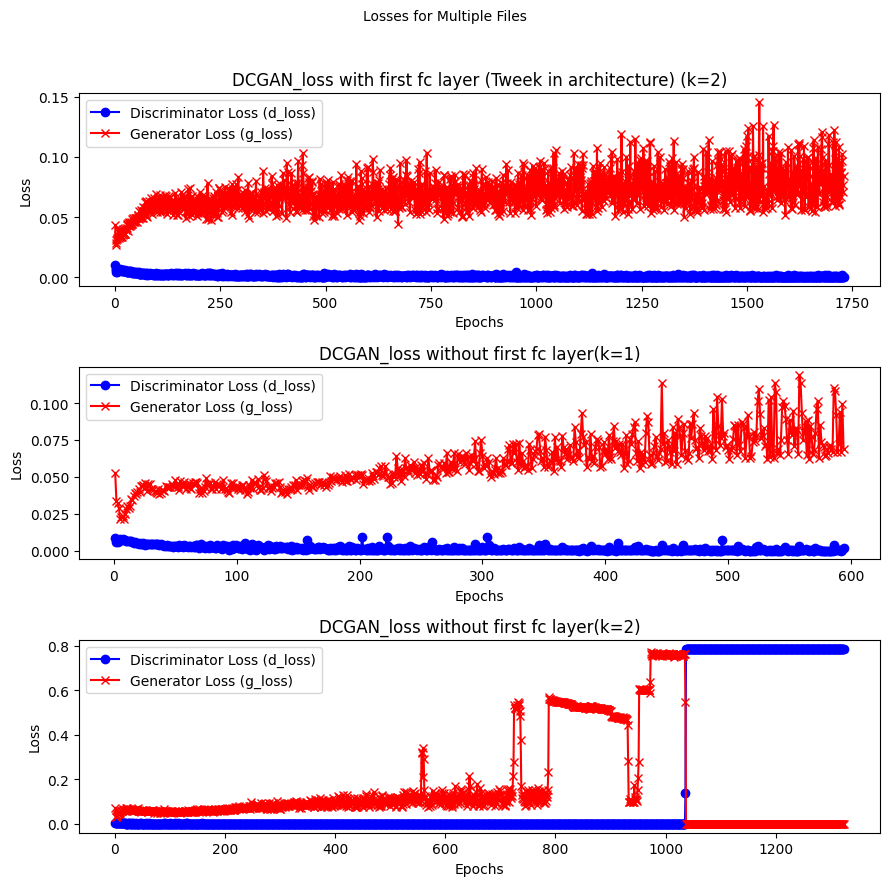

In [25]:
p1 = "/home/kawada-kuka/siddharth/ADRL/Losses/DCGAN/loss_k2_with_first_layer.txt"
t1 = "DCGAN_loss with first fc layer (Tweek in architecture) (k=2)"

p2 = "/home/kawada-kuka/siddharth/ADRL/Losses/DCGAN/loss_k1_without_first_layer.txt"
t2 = "DCGAN_loss without first fc layer(k=1)"

p3 = "/home/kawada-kuka/siddharth/ADRL/Losses/DCGAN/loss_k2_without_first_layer.txt"
t3 = "DCGAN_loss without first fc layer(k=2)"
file_paths = [p1,p2,p3]  # List of file paths
titles = [t1,t2,t3]
plot_loss(file_paths, titles,"Losses for Multiple Files")

#### Q4 FID

In [3]:
# Function to calculate the FID between two sets of images
def calculate_fid(real_images, generated_images, batch_size=32, device='cuda'):
    
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.fc = nn.Identity()  
    model.eval()  
    act1 = get_activations(real_images, model, batch_size, device)
    act2 = get_activations(generated_images, model, batch_size, device)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    fid_score = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid_score

def get_activations(images, model, batch_size, device):
    dataloader = DataLoader(images, batch_size=batch_size, shuffle=False)
    activations = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            pred = model(batch)
            activations.append(pred.cpu().numpy())
    
    activations = np.concatenate(activations, axis=0)
    return activations

# Function to preprocess images (resize and normalize)
def preprocess_images(images, image_size=(299, 299)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.Lambda(lambda x: (x + 1) / 2), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    processed_images = [preprocess(img) for img in images]
    return torch.stack(processed_images)


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    
    return fid

def compute_fid(model,data_loc):
    test_dataset = AnimalsDataset(data_loc)
    
    #Sample 1000 images from the dataset
    sample_indices = random.sample(range(len(test_dataset)), 1000)
    sample_images = [test_dataset[i][0] for i in sample_indices]
    
    #Generating 1000 images using the generator
    with torch.no_grad():
        z = torch.randn(1000, 100)
        img = model(z)
        
    img_list = [img[i] for i in range(1000)]
    img_list[0].shape
        
    preprocessed_real_images = preprocess_images(sample_images)
    preprocessed_generated_images = preprocess_images(img_list)
    
    fid_score = calculate_fid(preprocessed_real_images, preprocessed_generated_images)
    return fid_score

def compute_fid_cdcgan(model, data_loc, device = "cuda"):
    
    test_dataset = AnimalsDataset(data_loc)
    
    #Sample 1000 images from the dataset
    sample_indices = random.sample(range(len(test_dataset)), 1000)
    sample_images = [test_dataset[i][0] for i in sample_indices]
    sample_labels =  torch.tensor([test_dataset[i][1] for i in sample_indices])
    
    # Generating 1000 images using the generator conditioned on the sampled labels
    with torch.no_grad():
        z = torch.randn(1000, 200).to(device)  # Random noise vector
        sample_labels = sample_labels.to(device)
        generated_images = model(z, sample_labels)  # Generator output conditioned on labels
        
     # Preprocess real and generated images
    preprocessed_real_images = preprocess_images(sample_images).to(device)
    preprocessed_generated_images = preprocess_images(generated_images.cpu()).to(device)

    # Calculate FID
    fid_score = calculate_fid(preprocessed_real_images, preprocessed_generated_images)
    return fid_score
    

In [6]:
# Logging fid scores
# fid_log_file = '/home/kawada-kuka/siddharth/ADRL/Losses/DCGAN/fid_scores_k1_without_first_layer.txt'

# min_fid = float('inf')  
# min_fid_epoch = -1

# with open(fid_log_file, 'w') as fid_file:
#     for i in range(1, 595):
#         gen = torch.load(f'/home/kawada-kuka/siddharth/ADRL/models/DCGAN_k1_without_first_layer/epoch_{i}/generator_best.pth').to('cpu')
#         path = '/home/kawada-kuka/siddharth/ADRL/data_aug'
        
#         fid_score = compute_fid(gen, path)
        
#         fid_file.write(f"Epoch {i}, FID Score: {fid_score}\n")
#         fid_file.flush()

#         if fid_score < min_fid:
#             min_fid = fid_score
#             min_fid_epoch = i

/tmp/ipykernel_10129/2319115676.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(f'/home/kawada-kuka/siddharth/ADRL/models/DCGAN_k1_without_first_layer/e

For this question, we have plotted the FID scores against the number of epochs for k=1 and k=2 case without linear layer. The FID score has been computed by sampling 1000 images randomly from the true and generated distribution.  

For k=1 case, we have plotted FID scores for all models starting from epoch 0 to 600. Here, we have observed a clear trend showing that FID score decreases as the epochs increase, indicating a convergence on the true and the generated distribution based on the FID metric. The lowest FID score achieved was around 150 between epochs 590-600.
  
For k=2 case, due to insufficient memory, we couldn't save each and every model. Thus, the FID plot is only shown between epochs 300 and 400. Due to insufficient gap between the epochs, no clear trend can be concluded.



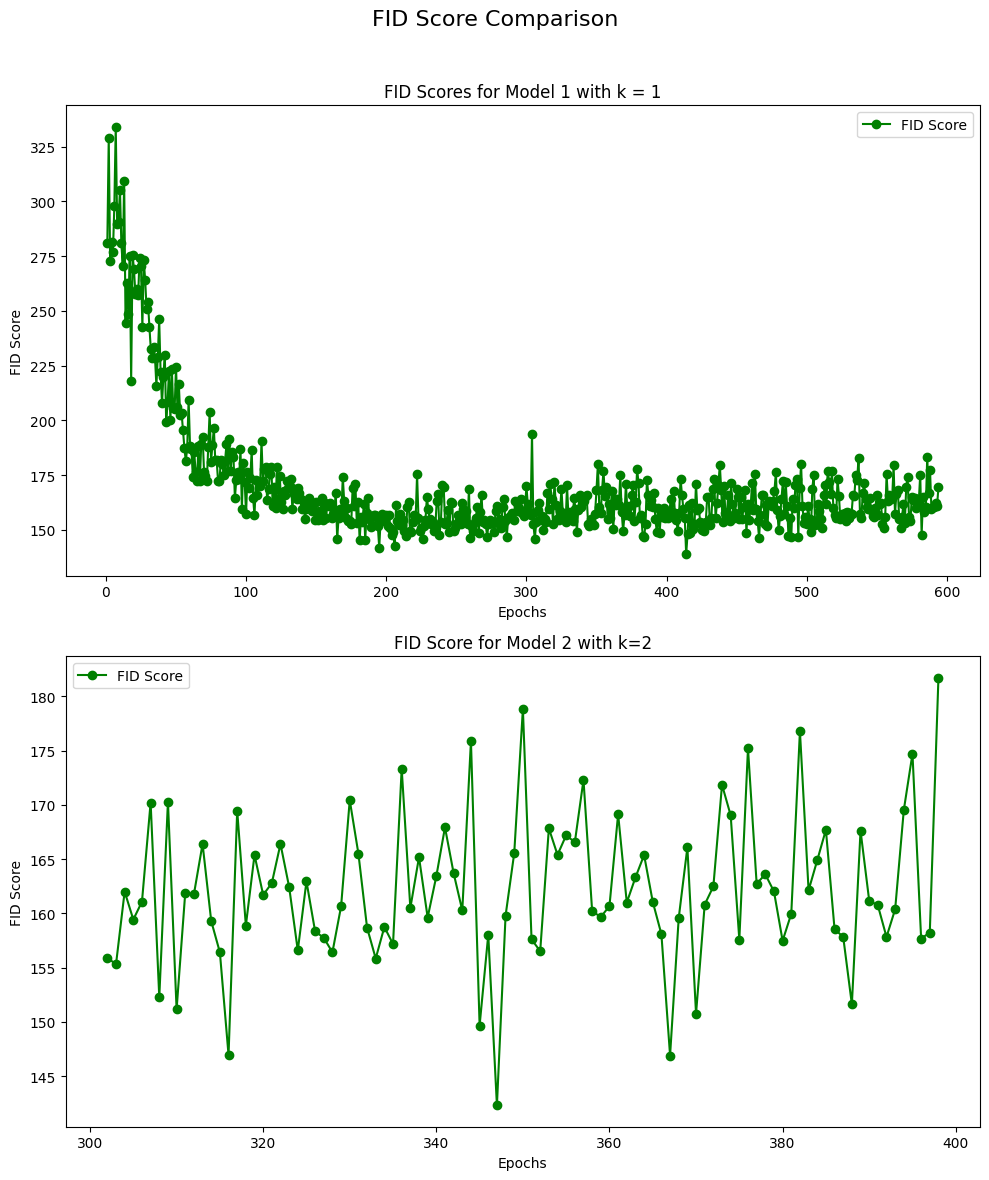

In [26]:
def plot_fid_subplots(paths, titles):
    num_files = len(paths)
    
    fig, axs = plt.subplots(num_files, 1, figsize=(10, 6 * num_files))
    fig.suptitle('FID Score Comparison', fontsize=16)  # Main title

    for i, path in enumerate(paths):
        fid_scores = []
        epochs = []
        
        with open(path, 'r') as file:
            for line in file:
                match = re.match(r"Epoch (\d+), FID Score: ([\d.]+)", line)
                if match:
                    epoch = int(match.group(1))
                    fid_score = float(match.group(2))
                    epochs.append(epoch)
                    fid_scores.append(fid_score)

        if num_files == 1:
            ax = axs
        else:
            ax = axs[i]

        ax.plot(epochs, fid_scores, label='FID Score', color='green', marker='o')
        ax.set_title(titles[i])  
        ax.set_xlabel('Epochs')
        ax.set_ylabel('FID Score')
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()

paths = ["/home/kawada-kuka/siddharth/ADRL/Losses/DCGAN/fid_scores_k1_without_first_layer.txt", 
         "/home/kawada-kuka/siddharth/ADRL/Losses/DCGAN/fid_scores_k2_without_first_layer.txt"]  # List of file paths

titles = ['FID Scores for Model 1 with k = 1', 'FID Score for Model 2 with k=2']  # Manually set titles

plot_fid_subplots(paths, titles)

#### Q5 Latent Traversals

We have defined two different types of latent traversals :  
1. Linear interpolation : $z_i = \alpha z_1 + (1 - \alpha)z_2$
2. Quadratic interpolation : $z_i = (1 - t)^2 \cdot z_1 + 2 \cdot (1 - t) \cdot t \cdot z_3 + t^2 \cdot z_2$  
where $z_3 = \frac{z_1 + z_2}{2}$

In [27]:
def linear_interpol(gen):
    z1 = torch.randn(1, 100).to("cuda")
    z2 = torch.randn(1, 100).to("cuda")
    alpha = 0.4
    #Linear interpolation between z1 and z2
    z_interp = alpha * z1 + (1 - alpha) * z2
    
    
    with torch.no_grad():
        img1 = gen(z1)
        img1 = img1.squeeze(0).permute(1, 2, 0).cpu().numpy()
        
        img1 = (img1 + 1) * 127.5
        img1 = img1.astype(int)
        img2 = gen(z2)
        img2 = img2.squeeze(0).permute(1, 2, 0).cpu().numpy()
        
        img2 = (img2 + 1) * 127.5
        img2 = img2.astype(int)
        img_interp = gen(z_interp)
        img_interp = img_interp.squeeze(0).permute(1, 2, 0).cpu().numpy()
        #Convert to 0-255 range
        img_interp = (img_interp + 1) * 127.5
        img_interp = img_interp.astype(int)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img1)
        plt.title('Image 1')
        plt.subplot(1, 3, 2)
        plt.imshow(img_interp)
        plt.title('Interpolated Image')
        plt.subplot(1, 3, 3)
        plt.imshow(img2)
        plt.title('Image 2')
        plt.show()
        
def Quadratic_interpol(gen):
    #Quadratic interpolation
    z1 = torch.randn(1, 100).to("cuda")
    z2 = torch.randn(1, 100).to("cuda")
    z3 = (z1 + z2)/2
    t = 0.4
    z_interp_q = (1 - t)**2 * z1 + 2 * (1 - t) * t * z3 + t**2 * z2
    
    with torch.no_grad():
        img1 = gen(z1)
        img1 = img1.squeeze(0).permute(1, 2, 0).cpu().numpy()
        
        img1 = (img1 + 1) * 127.5
        img1 = img1.astype(int)
        img2 = gen(z2)
        img2 = img2.squeeze(0).permute(1, 2, 0).cpu().numpy()
        
        img2 = (img2 + 1) * 127.5
        img2 = img2.astype(int)
        img_interp = gen(z_interp_q)
        img_interp = img_interp.squeeze(0).permute(1, 2, 0).cpu().numpy()
        
        img_interp = (img_interp + 1) * 127.5
        img_interp = img_interp.astype(int)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img1)
        plt.title('Image 1')
        plt.subplot(1, 3, 2)
        plt.imshow(img_interp)
        plt.title('Quadratic Interpolated Image')
        plt.subplot(1, 3, 3)
        plt.imshow(img2)
        plt.title('Image 2')
        plt.show()

As per the results, we obtain a smoother interpolation for the linear interpolation case, showing the transition between the two generated images through the interpolated image, depicting a latent space traversal.

/tmp/ipykernel_23044/4152797901.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(model_path)


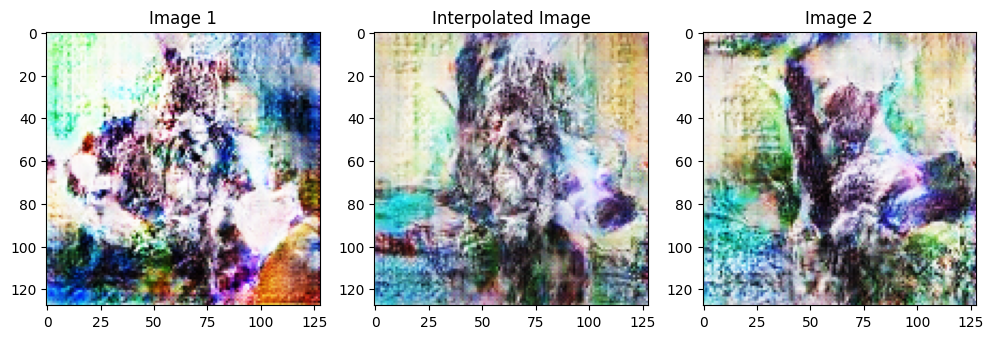

In [28]:
data_path = "/home/kawada-kuka/siddharth/ADRL/data_aug"
model_path = "/home/kawada-kuka/siddharth/ADRL/models/DCGAN_1/epoch_347/generator_best.pth"
gen = torch.load(model_path)
linear_interpol(data_path,gen)

/tmp/ipykernel_23044/4293087795.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(model_path)


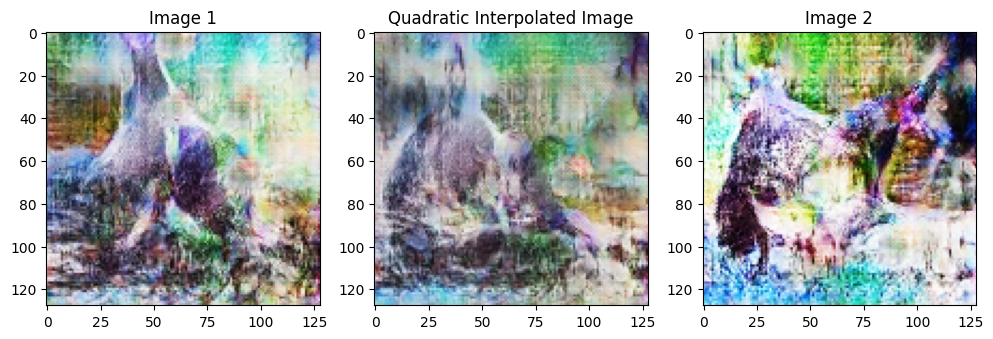

In [31]:
data_path = "/home/kawada-kuka/siddharth/ADRL/data_aug"
gen = torch.load(model_path)
Quadratic_interpol(gen)

#### Q6 Conditional-DCGAN

The proposed architecture consists of two key components: a **Conditional Generator** and a **Conditional Discriminator**, designed for a conditional GAN (CGAN).

1. **Conditional Generator**: 
   - It takes a noise vector \(z\) and a class label \(c\), embedding the class label using an embedding layer.
   - The noise and class embedding are concatenated and passed through a series of ConvTranspose2d layers with ReLU activations and batch normalization.
   - The output is an image generated in the range of \([-1, 1]\) using a Tanh activation.

2. **Conditional Discriminator**: 
   - It takes an input image and a class label. The label is embedded and reshaped to match the image size, then concatenated with the image.
   - The combined input passes through multiple Conv2d layers with LeakyReLU activations and batch normalization.
   - The output is a probability score, determining whether the image is real or fake, with a final Sigmoid activation.


In [4]:
class CModel(nn.Module):
    def __init__(self, feature_maps_g, z_dim, img_channels, feature_maps_d, num_classes,c_dim):
        super(CModel, self).__init__()
        # Initialize
        self.generator = ConditionalGenerator(feature_maps=feature_maps_g, z_dim=z_dim, img_channels=img_channels,num_classes=num_classes,c_dim = c_dim)
        self.discriminator = ConditionalDiscriminator(img_channels=img_channels, feature_maps=feature_maps_d, num_classes = num_classes)
    def generate(self, z, c):
        return self.generator(z,c)

    def discriminate(self, x, c):
        return self.discriminator(x,c)

#Architecture for Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, feature_maps=1024, z_dim=200, img_channels=3, num_classes = 20, c_dim = 200):
        super(ConditionalGenerator, self).__init__()
        
        self.embedding = nn.Embedding(num_classes, c_dim)
        
        # self.fc1 = nn.Linear(z_dim + c_dim, 200)
        # self.leaky_relu = nn.LeakyReLU(0.2)
        
        self.generator = nn.Sequential(
            # Input
            nn.ConvTranspose2d(z_dim+c_dim, feature_maps, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # First layer
            nn.ConvTranspose2d(feature_maps, feature_maps // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 2),
            nn.ReLU(True),

            # Second layer
            nn.ConvTranspose2d(feature_maps // 2, feature_maps // 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 4),
            nn.ReLU(True),

            # Third layer
            nn.ConvTranspose2d(feature_maps // 4, feature_maps // 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 8),
            nn.ReLU(True),

            # Fourth layer
            nn.ConvTranspose2d(feature_maps // 8, feature_maps // 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 16),
            nn.ReLU(True),

            # Fifth layer
            nn.ConvTranspose2d(feature_maps // 16, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Tanh activation for image output in range [-1, 1]
        )
    
    def forward(self, z, c):
        
        label_embedding = self.embedding(c)
        
        x = torch.cat([z, label_embedding], dim = 1)
        # print(x.shape)
        # x = self.fc1(x)
        # x = self.leaky_relu(x)
        x = x.view(x.size(0), -1, 1, 1)  # Reshape the latent vector into (batch_size, latent_dim, 1, 1)
        return self.generator(x)
    
    
#Architecture for Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, img_channels=3, feature_maps=64, num_classes = 20, img_size = 128):
        super(ConditionalDiscriminator, self).__init__()
        
        self.embedding = nn.Embedding(num_classes,img_size*img_size)
 
        # Define the discriminator network with Conv2d layers
        self.discriminator = nn.Sequential(
            # Input
            nn.Conv2d(img_channels + 1, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), 
 
            # Layer 2
            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 3
            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 4
            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 5
            nn.Conv2d(feature_maps * 8, feature_maps * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 16),
            nn.LeakyReLU(0.2, inplace=True),
 
            # Layer 6
            nn.Conv2d(feature_maps * 16, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
 
    def forward(self, x, c):
        
        label_embedding = self.embedding(c)
        label_embedding = label_embedding.view(c.shape[0],1, x.size(2), x.size(3))
        
        x = torch.cat([x, label_embedding], dim=1)
        return self.discriminator(x)
        

In [6]:
# # Instantiate the model
# model = CModel(feature_maps_g=feature_maps_g, z_dim=100, img_channels=img_channels, 
#               feature_maps_d=feature_maps_d, num_classes=20, c_dim=100).to(device)

In [7]:
# images = torch.randn(32, 100).to(device)  # Latent vector
# c = torch.randint(0, 20, (32,)).to(device)  # Random labels for fake data
# print(c)
# print(c.shape)
# fake_images = model.generate(z, c)


# fake_preds = model.discriminate(fake_images, c)

In [5]:
def train_conditional_dcgan(data_loader, model, latent_dim, device, num_epochs=100, k=1, learning_rate=0.001):
    model.train()
    # Optimizers
    opt_gen = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    opt_disc = optim.Adam(model.discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Path to the loss log file
    loss_log_path = '/home/kawada-kuka/siddharth/ADRL/Losses/Conditional DCGAN/CDCGAN.txt'

    if not os.path.exists(loss_log_path):
        with open(loss_log_path, 'w') as loss_log_file:
            loss_log_file.write("Epoch, d_loss, g_loss\n")  
            

    for epoch in range(num_epochs):
        datapoints = 0
        total_gen_loss = 0
        total_disc_loss = 0

        # Use tqdm to show the progress bar with loss updates
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

        for i, (real_images, labels) in progress_bar:
            real_images = real_images.to(device)
            labels = labels.to(device)
            batch_size = real_images.size(0)

            # Train Discriminator k times
            for _ in range(k):      
                
                z = torch.randn(batch_size, latent_dim).to(device)  
                fake_images = model.generate(z, labels)
   
                # Discriminator on real images
                real_preds = model.discriminate(real_images, labels)
                # print(real_preds)
                d_loss_real = criterion(real_preds, torch.ones_like(real_preds))

                # Discriminator on fake images
                fake_preds = model.discriminate(fake_images.detach(), labels)
                d_loss_fake = criterion(fake_preds, torch.zeros_like(fake_preds))  

                d_loss = d_loss_real + d_loss_fake
                opt_disc.zero_grad()
                d_loss.backward()
                opt_disc.step()

            # Train Generator once
            opt_gen.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)  # Latent vector

            fake_images = model.generate(z, labels)
            fake_preds = model.discriminate(fake_images, labels)

            g_loss = criterion(fake_preds, torch.ones_like(fake_preds))  
            
            g_loss.backward()
            opt_gen.step()

            total_disc_loss += d_loss.item()
            total_gen_loss += g_loss.item()

            datapoints += real_images.size(0)
            avg_disc_loss = total_disc_loss / datapoints
            avg_gen_loss = total_gen_loss / datapoints

            progress_bar.set_postfix({
                'd_loss': f'{avg_disc_loss:.4f}',
                'g_loss': f'{avg_gen_loss:.4f}'
            })
            
            with open(loss_log_path, 'a') as loss_log_file:
                loss_log_file.write(f'{epoch + 1}, {avg_disc_loss:.4f}, {avg_gen_loss:.4f}\n')
                loss_log_file.flush() 
        
            if epoch==50 or epoch==90 or epoch==99:
                folder_name = f'/home/kawada-kuka/siddharth/ADRL/models/Conditional DCGAN/epoch_{epoch+1}'
                os.makedirs(folder_name, exist_ok=True)
                torch.save(model.generator, os.path.join(folder_name, 'generator_best.pth'))
                torch.save(model.discriminator, os.path.join(folder_name, 'discriminator_best.pth'))
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {avg_disc_loss:.4f}, g_loss: {avg_gen_loss:.4f}')

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32
z_dim = 100
c_dim = 100
num_classes = 20
feature_maps_g = 1024
feature_maps_d = 64
img_channels = 3
learning_rate = 0.0002
num_epochs = 100
k = 1

# Instantiate the model
model = CModel(feature_maps_g=feature_maps_g, z_dim=z_dim, img_channels=img_channels, 
              feature_maps_d=feature_maps_d, num_classes=num_classes, c_dim=c_dim)
model.to(device)

# DataLoader
data_loader = DataLoader(AnimalsDataset(data_loc), batch_size=batch_size, shuffle=True)

# Call the training function
train_conditional_dcgan(data_loader, model, z_dim, device=device, num_epochs=num_epochs, k=k, learning_rate=learning_rate)


Epoch [1/100]: 100%|██████████| 75/75 [00:02<00:00, 28.24it/s, d_loss=0.0442, g_loss=0.1047]


Epoch [1/100], d_loss: 0.0442, g_loss: 0.1047


Epoch [2/100]: 100%|██████████| 75/75 [00:02<00:00, 28.41it/s, d_loss=0.0370, g_loss=0.0805]


Epoch [2/100], d_loss: 0.0370, g_loss: 0.0805


Epoch [3/100]: 100%|██████████| 75/75 [00:02<00:00, 28.35it/s, d_loss=0.0384, g_loss=0.0688]


Epoch [3/100], d_loss: 0.0384, g_loss: 0.0688


Epoch [4/100]: 100%|██████████| 75/75 [00:02<00:00, 28.26it/s, d_loss=0.0399, g_loss=0.0684]


Epoch [4/100], d_loss: 0.0399, g_loss: 0.0684


Epoch [5/100]:  32%|███▏      | 24/75 [00:00<00:01, 27.89it/s, d_loss=0.0424, g_loss=0.0565]


KeyboardInterrupt: 

##### Inference on C DCGAN

In [13]:
data_loc = "/home/kawada-kuka/siddharth/ADRL/data_CDCGAN"
sample_dataset = AnimalsDataset(data_loc)

In [22]:
label_map = {'chimpanzee': 0,
 'bear': 1,
 'cat': 2,
 'bat': 3,
 'donkey': 4,
 'coyote': 5,
 'antelope': 6,
 'boar': 7,
 'crab': 8,
 'badger': 9,
 'butterfly': 10,
 'bison': 11,
 'deer': 12,
 'beetle': 13,
 'cow': 14,
 'dog': 15,
 'caterpillar': 16,
 'cockroach': 17,
 'bee': 18,
 'crow': 19}
reverse_label_map = {v: k for k, v in label_map.items()}

/tmp/ipykernel_8297/1824106370.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  c_gen = torch.load("/home/kawada-kuka/siddharth/ADRL/models/Conditional_DCGAN_k2/epoch_901

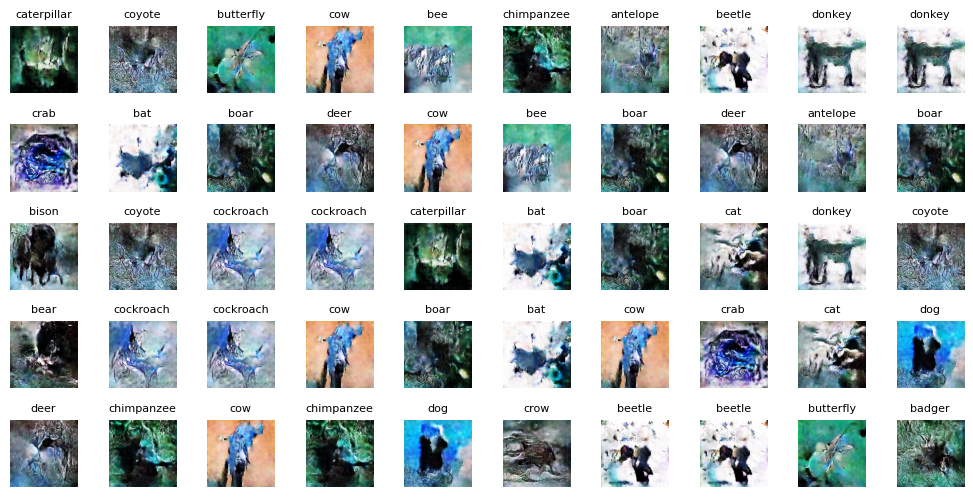

In [38]:
c_gen = torch.load("/home/kawada-kuka/siddharth/ADRL/models/Conditional_DCGAN_k2/epoch_901/generator_best.pth").to("cpu")

def generate_images(generator, num_samples, z_dim, num_classes, device):
    z = torch.randn(num_samples, z_dim).to(device)
    random_labels = torch.randint(0, num_classes, (num_samples,)).to(device)
    with torch.no_grad():
        generated_images = generator(z, random_labels)
    return generated_images, random_labels

def plot_images(images, labels, grid_size = 10):
    images = (images + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    num_images = len(images)

    plt.figure(figsize=(grid_size, grid_size))
    
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        img = images[i].cpu().numpy().transpose(1, 2, 0)  
        plt.imshow(img)
        class_name = reverse_label_map[labels[i].item()]
        plt.title(f'{class_name}', fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
# Set parameters
num_samples = 50
z_dim = 200        
num_classes = 20   
c_dim = 200        

# Generate images
generated_images, labels = generate_images(c_gen, num_samples, z_dim, num_classes, "cpu")

plot_images(generated_images, labels)

The following code calculates the Fréchet Inception Distance (FID) score for a series of Conditional DCGAN models. The FID score is computed for each model saved during training, and the epoch with the minimum FID score is recorded.

1. **FID Log File**: The FID scores for each epoch are logged to the file located at \texttt{fid\_scores\_k1.txt}.
   
2. **Epoch Range**: The loop iterates through model checkpoints from epoch 102 to epoch 500.
   
3. **Model Loading**: For each epoch, the generator model is loaded using \texttt{torch.load()} and moved to the CUDA device for evaluation.
   
4. **FID Calculation**: The function \texttt{compute\_fid\_cdcgan()} is called to compute the FID score for the generator with respect to the real images from the dataset at \texttt{data\_CDCGAN}.
   
5. **Tracking Minimum FID**: The FID score for each epoch is compared with the minimum FID score found so far. If a lower FID score is encountered, it is updated, and the epoch is stored.

6. **Results**: The FID score and corresponding epoch with the lowest FID score are printed at the end of the loop.


In [36]:
# Calculating fid
fid_log_file = '/home/kawada-kuka/siddharth/ADRL/Losses/Conditional DCGAN/fid_scores_k1.txt'

min_fid = float('inf')  
min_fid_epoch = -1

with open(fid_log_file, 'w') as fid_file:
    for i in range(102, 501):
        gen = torch.load(f"/home/kawada-kuka/siddharth/ADRL/models/Conditional DCGAN/epoch_{i}/generator_best.pth").to("cuda")
        path = "/home/kawada-kuka/siddharth/ADRL/data_CDCGAN"
        
        fid_score = compute_fid_cdcgan(gen, path)
        
        fid_file.write(f"Epoch {i}, FID Score: {fid_score}\n")
        fid_file.flush()

        if fid_score < min_fid:
            min_fid = fid_score
            min_fid_epoch = i
         
print("Min_fid_epoch======>",min_fid_epoch,"\n min fid", min_fid)   

/tmp/ipykernel_7716/538533133.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(f"/home/kawada-kuka/siddharth/ADRL/models/Conditional DCGAN/epoch_{i}/gene

Min_fid_epoch======> 426 
 min fid 284.25057378047353


In [33]:
data_loc = "/home/kawada-kuka/siddharth/ADRL/data_CDCGAN"
model_path = "/home/kawada-kuka/siddharth/ADRL/models/Conditional DCGAN/epoch_102/generator_best.pth"
gen = torch.load(model_path).to("cuda")
fid_score = compute_fid_cdcgan(gen, data_loc)

/tmp/ipykernel_7716/2341519760.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(model_path).to("cuda")


##### Plotting FIDs and Losses

We experimented with several hyperparameters to fine-tune the performance of the conditional GAN model:

1. **Batch Size**: Set to 64, providing a balance between computational efficiency and model convergence.
   
2. **Latent Dimension** (\(z\_dim\)): A 100-dimensional noise vector \(z\) was used, which we found to generate diverse outputs while maintaining reasonable computational costs.
   
3. **Conditional Embedding Dimension** (\(c\_dim\)): Set to 100, representing the dimensionality of the class embedding. This dimension was tested to ensure that the generator can effectively integrate class information.
   
4. **Number of Classes** (\(num\_classes\)): We worked with 20 distinct classes in the dataset, represented by embeddings within the model.
   
5. **Generator Feature Maps** (\(feature\_maps\_g\)): Initially set to 1024, this defines the depth of the feature maps in the generator. This value was chosen to allow the model to capture high-level representations effectively.
   
6. **Discriminator Feature Maps** (\(feature\_maps\_d\)): Set to 64, controlling the number of feature maps in the discriminator's first layer, allowing for progressively deeper feature extraction.

7. **Learning Rate**: Set at 0.0002, we tested different learning rates and found this value to provide stable training with a good balance between speed and convergence.

8. **Number of Epochs**: Set to 4000 epochs, providing sufficient time for the model to learn and improve, given the size of the dataset and complexity of the task.

9. **Discriminator Update Frequency** (\(k\)): Set to 2, meaning the discriminator is updated once for each generator update. This was fine-tuned to maintain a balance between the generator and discriminator during training.

These hyperparameters were selected after testing various combinations to ensure stable and efficient training of the conditional DCGAN model.


##### Loss Behaviour

The following code generates and plots the loss curves for the generator and discriminator in a Conditional DCGAN model, using two different configurations with \( k = 1 \) and \( k = 2 \). The losses are logged in separate files for each configuration, and then both are plotted for comparison.

1. **Loss Files**: 
   - For \( k = 1 \): The generator and discriminator losses are saved in the file located at \texttt{loss\_k1.txt}.
   - For \( k = 2 \): The losses are saved in the file located at \text{loss\_k2.txt}.
   
2. **Plotting**: The function \texttt{plot\_loss()} is used to plot the losses from both configurations on a single graph with corresponding titles.
   
3. **Loss Behavior**:
   - The discriminator loss is observed to decrease over time, which is typical as the discriminator learns to better distinguish between real and generated images.
   - The generator loss, on the other hand, is seen to increase over time, indicating that the generator is struggling to fool the discriminator effectively. This behavior is often seen when the generator is not improving at the same rate as the discriminator.

The plot shows the evolution of both losses across different epochs, allowing for comparison of the learning dynamics between the two configurations.


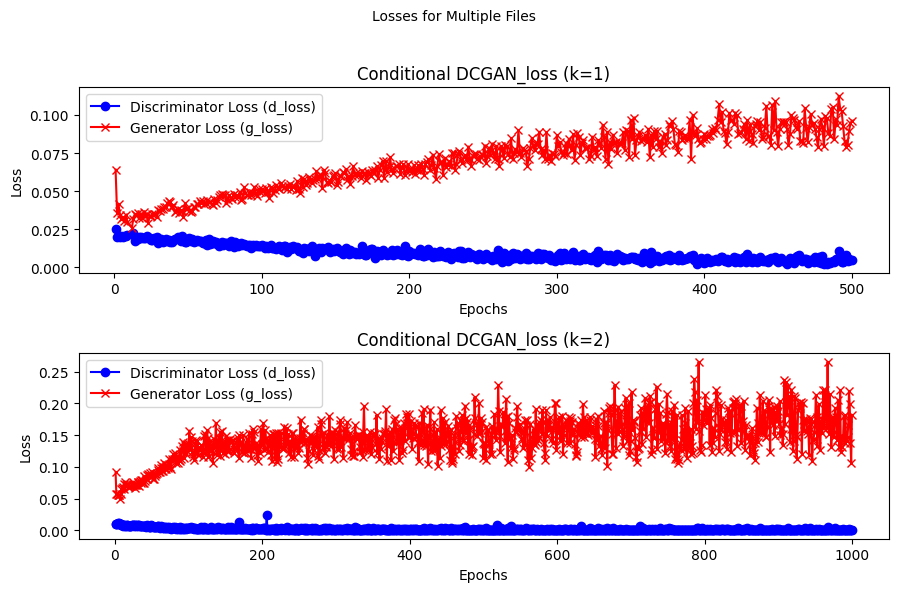

In [28]:
p1 = "/home/kawada-kuka/siddharth/ADRL/Losses/Conditional DCGAN/loss_k1.txt"
t1 = "Conditional DCGAN_loss (k=1)"

p2 = "/home/kawada-kuka/siddharth/ADRL/Losses/Conditional DCGAN/loss_k2.txt"
t2 = "Conditional DCGAN_loss (k=2)"

file_paths = [p1,p2]  
titles = [t1,t2]
plot_loss(file_paths, titles,"Losses for Multiple Files")


The FID scores for the two models with \( k = 1 \) and \( k = 2 \) were evaluated across multiple epochs, and the results were plotted using the function \texttt{plot\_fid\_subplots()}.

1. **Model with \( k = 1 \)**: 
   - The FID scores consistently fluctuate decreasingly over the entire 500 epochs, indicating that the generated images are improving in quality over time. This is typically an indication that the model is learning to generate images that are increasingly similar to the real images.

2. **Model with \( k = 2 \)**: 
   - The FID scores decrease for the first 100 epochs, after which they begin to increase until the 1000th epoch. This pattern suggests that although the model initially improves, after a certain point it starts to overfit or struggles to maintain the quality of the generated images.
   - Despite the increasing FID scores, the images generated by this model are visually better than the images from the \( k = 1 \) model. This suggests that while the FID score may not be improving after a certain point, the perceptual quality of the generated images could still be superior.

3. **Interpretation**:
   - The FID score is a useful metric for quantitatively assessing the quality of generated images, but it does not always correlate perfectly with human perception. In this case, the images generated by the \( k = 2 \) model appear better, even though the FID score begins to increase after a certain number of epochs.
   - This highlights the potential limitations of relying solely on FID for evaluating model performance, as it might not always reflect perceptual quality.


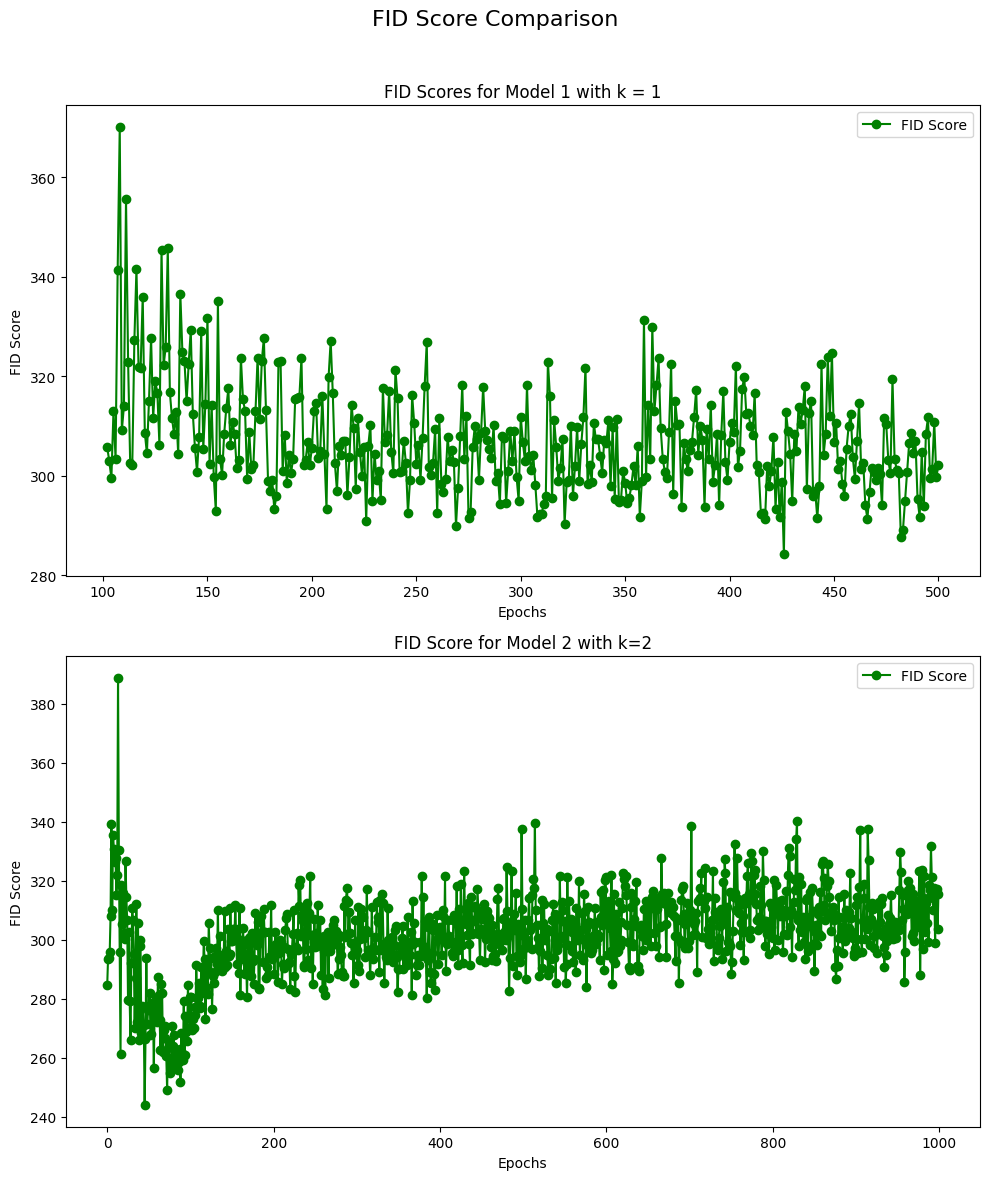

In [29]:
paths = ["/home/kawada-kuka/siddharth/ADRL/Losses/Conditional DCGAN/fid_scores_k1.txt", 
         "/home/kawada-kuka/siddharth/ADRL/Losses/Conditional DCGAN/fid_scores_k2.txt"]  # List of file paths

titles = ['FID Scores for Model 1 with k = 1', 'FID Score for Model 2 with k=2']  # Manually set titles

plot_fid_subplots(paths, titles)

#### Q7 W GAN

For WGAN, the generator architecture is same as in Q1. However, the critic architecture has been slightly modified. We removed the last layer of the discriminator and added a linear layer to output a single score. 

In [3]:
class WGenerator(nn.Module):
    def __init__(self, feature_maps=1024, latent_dim=100, img_channels=3):
        super(WGenerator, self).__init__()
        #self.fc1 = nn.Linear(100, 100)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.upsampler = nn.Sequential(
            # First layer
            nn.ConvTranspose2d(latent_dim, feature_maps, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # Second layer
            nn.ConvTranspose2d(feature_maps, feature_maps // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 2),
            nn.ReLU(True),

            # Third layer
            nn.ConvTranspose2d(feature_maps // 2, feature_maps // 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 4),
            nn.ReLU(True),

            # Fourth layer
            nn.ConvTranspose2d(feature_maps // 4, feature_maps // 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 8),
            nn.ReLU(True),

            # Fifth layer
            nn.ConvTranspose2d(feature_maps // 8, feature_maps // 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 16),
            nn.ReLU(True),

            # Sixth layer
            nn.ConvTranspose2d(feature_maps // 16, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        # x = self.fc1(x)
        # x = self.leaky_relu(x)
        x = x.view(x.size(0), -1, 1, 1)  # Reshape the latent vector into (batch_size, latent_dim, 1, 1)
        return self.upsampler(x)
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        
        # Critic's architecture
        self.model = nn.Sequential(
            # Input: (3, 128, 128)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            
            nn.Linear(1024 * 4 * 4, 1) 
        )

    def forward(self, x):
        score =  self.model(x)
        score = score.view(-1)
        return score

In [4]:
class WGAN(nn.Module):
    def __init__(self):
        super(WGAN, self).__init__()
        self.gen = WGenerator()
        self.critic = Critic()
        
    def forward(self, x):
        x = self.gen(x)
        x = self.critic(x)
        return x

In [ ]:
# wgan = WGAN()
# x = torch.randn(10, 100)
# wgan(x).shape

##### Training for WGAN

1. Training code with weight normalization

In [9]:
def WGAN_trainer_weight_normalization(model, dataloader, latent_dim=100, n_epochs=2, k=2, clip_value=0.01, lr=5e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    generator = model.gen
    critic = model.critic
    optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
    optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)
    
    # Path to the loss log file
    loss_log_path = '/home/kawada-kuka/siddharth/ADRL/Losses/WGAN/WGAN.txt'

    
    if not os.path.exists(loss_log_path):
        with open(loss_log_path, 'w') as loss_log_file:
            loss_log_file.write("Epoch, d_loss, g_loss\n")
      
    
    for epoch in range(n_epochs):
        tqdm_batch = tqdm(dataloader, desc=f"Epoch 0/{n_epochs}")
        total_gen_loss = 0
        total_critic_loss = 0
        num_data = 0
        for batch in tqdm_batch:
            real_images = batch[0].to(device)            
            # Train Critic
            for _ in range(k):
                optimizer_C.zero_grad()

                # Sample noise and generate fake images
                z = torch.randn(real_images.size(0), latent_dim).to(device)
                fake_images = generator(z)

                # Compute critic loss
                critic_real = critic(real_images)
                critic_fake = critic(fake_images)
                critic_loss = (torch.mean(critic_real) - torch.mean(critic_fake))

                # Backprop and update critic
                critic_loss.backward()
                optimizer_C.step()

                # Clip weights of critic to enforce Lipschitz constraint
                for p in critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            # Train Generator every n_critic iterations
            optimizer_G.zero_grad()

            # Generate fake images and compute generator loss
            z = torch.randn(real_images.size(0), latent_dim).to(device)
            fake_images = generator(z)
            generator_loss = -torch.mean(critic(fake_images))  

            # Backprop and update generator
            generator_loss.backward()
            optimizer_G.step()
            total_gen_loss += generator_loss.item()
            total_critic_loss += critic_loss.item()
            num_data += real_images.size(0)
            avg_gen_loss = total_gen_loss / num_data
            avg_critic_loss = total_critic_loss / num_data
            tqdm_batch.set_postfix(critic_loss=avg_critic_loss, gen_loss=avg_gen_loss)
        
        
        with open(loss_log_path, 'a') as loss_log_file:
                loss_log_file.write(f'{epoch + 1}, {avg_critic_loss:.4f}, {avg_gen_loss:.4f}\n')
                loss_log_file.flush()  
        
        if epoch>100:
            # Create a folder named after the epoch number
            folder_name = f'/home/kawada-kuka/siddharth/ADRL/models/WGAN/epoch_{epoch+1}'
            os.makedirs(folder_name, exist_ok=True)

            # Save the generator and discriminator models in the folder
            torch.save(generator, os.path.join(folder_name, 'generator_best.pth'))
            torch.save(critic, os.path.join(folder_name, 'discriminator_best.pth'))
            
        print(f"Epoch [{epoch+1}/{n_epochs}], Critic Loss: {avg_critic_loss}, Generator Loss: {avg_gen_loss}")


2. Training code with gradient penalty

In [1]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """Computes the gradient penalty for WGAN-GP."""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.randn(real_samples.size(0), 1, 1, 1, device=device).expand_as(real_samples)
    
    # Get interpolated images
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    critic_interpolates = critic(interpolates)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(critic_interpolates.size(), device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def WGAN_trainer_gradient_clipping(model, dataloader, latent_dim=100, n_epochs=2, k=1, lambda_gp=10, lr=5e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    generator = model.gen
    critic = model.critic
    optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
    optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)
    
    # Path to the loss log file
    loss_log_path = '/home/kawada-kuka/siddharth/ADRL/Losses/WGAN_gp/k1.txt'

    if not os.path.exists(loss_log_path):
        with open(loss_log_path, 'w') as loss_log_file:
            loss_log_file.write("Epoch, d_loss, g_loss\n")
      
    for epoch in range(n_epochs):
        tqdm_batch = tqdm(dataloader, desc=f"Epoch 0/{n_epochs}")
        total_gen_loss = 0
        total_critic_loss = 0
        num_data = 0
        for batch in tqdm_batch:
            real_images = batch[0].to(device)            
            # Train Critic
            for _ in range(k):
                optimizer_C.zero_grad()

                # Sample noise and generate fake images
                z = torch.randn(real_images.size(0), latent_dim).to(device)
                fake_images = generator(z)

                # Compute critic loss
                critic_real = critic(real_images)
                critic_fake = critic(fake_images)
                critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake))  # For gradient ascent
                
                # Compute gradient penalty
                gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images, device)
                
                # Total loss = critic loss + lambda * gradient penalty
                total_critic_loss_value = critic_loss + lambda_gp * gradient_penalty

                # Backprop and update critic
                total_critic_loss_value.backward()
                optimizer_C.step()

            # Train Generator every k critic iterations
            optimizer_G.zero_grad()

            # Generate fake images and compute generator loss
            z = torch.randn(real_images.size(0), latent_dim).to(device)
            fake_images = generator(z)
            generator_loss = -torch.mean(critic(fake_images))  # Generator minimizes this

            # Backprop and update generator
            generator_loss.backward()
            optimizer_G.step()

            total_gen_loss += generator_loss.item()
            total_critic_loss += total_critic_loss_value.item()
            num_data += real_images.size(0)
            avg_gen_loss = total_gen_loss / num_data
            avg_critic_loss = total_critic_loss / num_data
            tqdm_batch.set_postfix(critic_loss=avg_critic_loss, gen_loss=avg_gen_loss)
        
        with open(loss_log_path, 'a') as loss_log_file:
            loss_log_file.write(f'{epoch + 1}, {avg_critic_loss:.4f}, {avg_gen_loss:.4f}\n')
            loss_log_file.flush()
        
        if epoch % 50 == 0:
            folder_name = f'/home/kawada-kuka/siddharth/ADRL/models/WGAN_gp_k1/epoch_{epoch+1}'
            os.makedirs(folder_name, exist_ok=True)

            torch.save(generator, os.path.join(folder_name, 'generator_best.pth'))
            torch.save(critic, os.path.join(folder_name, 'discriminator_best.pth'))

        print(f"Epoch [{epoch+1}/{n_epochs}], Critic Loss: {avg_critic_loss}, Generator Loss: {avg_gen_loss}")

In [73]:
data_folder = "/home/kawada-kuka/siddharth/ADRL/data_aug"
WGAN_model = WGAN()
train_dataset = AnimalsDataset(data_folder)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

We initially trained with weight normalization, but on inference, the results were not satisfactory, so we trained the WGAN model primarily with gradient clipping method. So, here we are listing the hyperparameters for WGAN with gradient clipping (same were used for weight normalization) :
Latent dimension of input random variable (z) = 100   
No. of epochs = 4000  
Batch size = 64  
No. of feature maps in first layer of generator = 1024  
No. of feature maps in first layer of critic = 64  
Optimizer = RMSProp [4]  
Starting learning rate = 0.00005
Gradient penalty = 10 ($\lambda$)

Variable hyperparameters:
k = 1, 2


In [ ]:
WGAN_trainer_gradient_clipping(WGAN_model, train_loader, n_epochs=500)

In [9]:
fid_log_file = '/home/kawada-kuka/siddharth/ADRL/Losses/WGAN/fid_scores_wgan.txt'

min_fid = float('inf')  
min_fid_epoch = -1

with open(fid_log_file, 'w') as fid_file:
    for i in range(102, 501):
        gen = torch.load(f'/home/kawada-kuka/siddharth/ADRL/models/WGAN/epoch_{i}/generator_best.pth').to('cpu')
        path = '/home/kawada-kuka/siddharth/ADRL/data_aug'
        
        fid_score = compute_fid(gen, path)
        
        fid_file.write(f"Epoch {i}, FID Score: {fid_score}\n")
        fid_file.flush()

        if fid_score < min_fid:
            min_fid = fid_score
            min_fid_epoch = i

/tmp/ipykernel_7716/2567219513.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(f'/home/kawada-kuka/siddharth/ADRL/models/WGAN/epoch_{i}/generator_best.p

We have plotted the training losses and FID scores against the epochs. For k=1, we again observe a clear decreasing trend in FID. But for k=2, although the trend is decreasing, it is more unstable comprising of frequent spikes compared to k=1 case. This gives us an intuitive idea that probably for WGAN case, training is more stable for k=1 case. 

##### Plot losses and FIDs

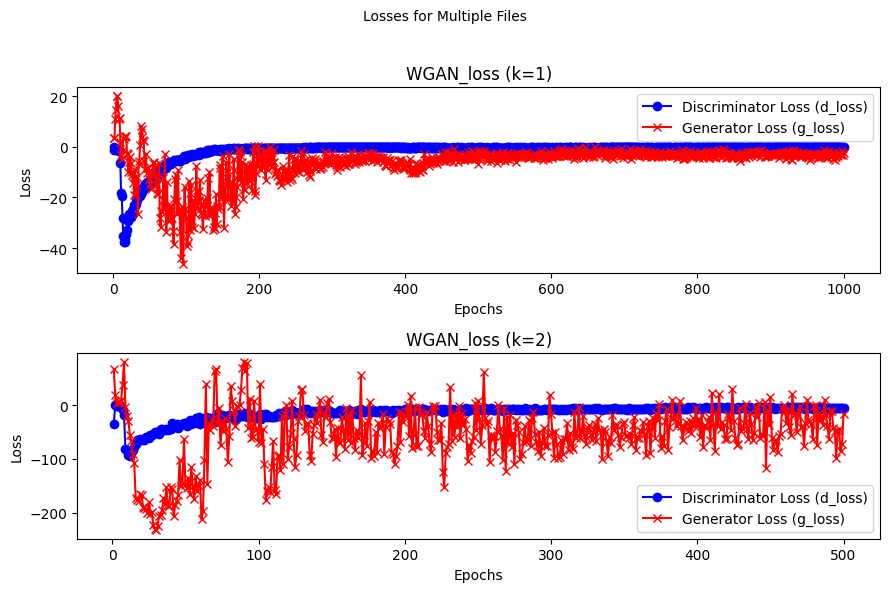

In [32]:
p1 = "/home/kawada-kuka/siddharth/ADRL/Losses/WGAN/loss_k1.txt"
t1 = "WGAN_loss (k=1)"

p2 = "/home/kawada-kuka/siddharth/ADRL/Losses/WGAN/loss_k2.txt"
t2 = "WGAN_loss (k=2)"

file_paths = [p1,p2]  
titles = [t1,t2]
plot_loss(file_paths, titles,"Losses for Multiple Files")

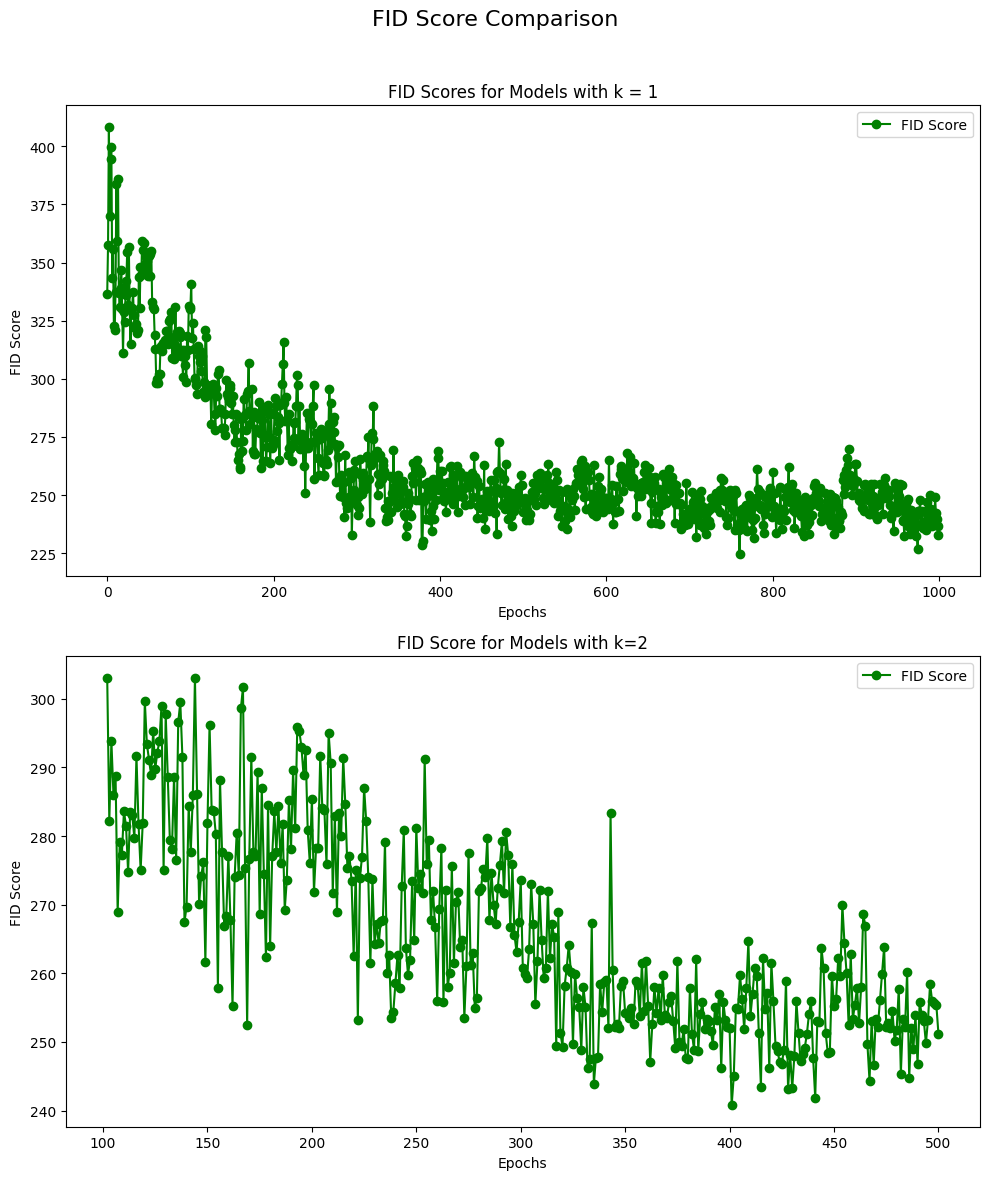

In [30]:
paths = ["/home/kawada-kuka/siddharth/ADRL/Losses/WGAN/fid_scores_k1.txt", 
         "/home/kawada-kuka/siddharth/ADRL/Losses/WGAN/fid_scores_k2.txt"]

titles = ['FID Scores for Models with k = 1', 'FID Score for Models with k=2']  

plot_fid_subplots(paths, titles)

WGAN inference

Here we have plotted the WGAN inference results for the best model (subjective human evaluation). The best model was obtained for WGAN trained with gradient penalty for k=1, epoch 701.  
The results appear to be visually more semantic than the results obtained for DCGAN in Q1

/tmp/ipykernel_19291/4034757532.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(model_path).to('cpu')


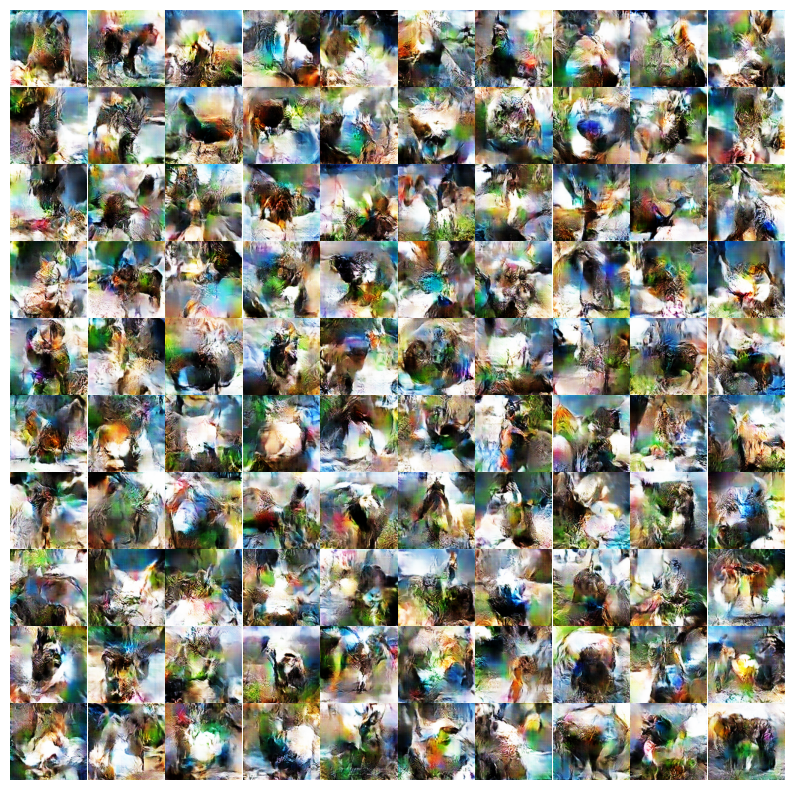

In [37]:
def plot_img_dcgan(model_path):
    gen = torch.load(model_path).to('cpu')

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))

    with torch.no_grad():
        for i in range(10):
            for j in range(10):
                z = torch.randn(1, 100)  
                img = gen(z)  
                img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  
                img = (img + 1) * 127.5
                img = img.astype(np.uint8)
                img = img[..., ::-1]  
                axes[i, j].imshow(img)
                axes[i, j].axis('off')  

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

model_path = "/home/kawada-kuka/siddharth/ADRL/models/WGAN_gp_k1/epoch_701/generator_best.pth"

plot_img_dcgan(model_path)

#### Q8 Extra Decoder Architecture

For training the decoder, we designed a class called ReverseGAN. The architecture for ReverseGAN is just the opposite of Generator architecture described in Q1. Instead of upsampling, we have downsampled in each layer. Thus we have replaced transpose convolution layers with convolution layers. The Generator and Discriminator have same architecture as before. 

In [13]:
class ReverseGAN(nn.Module):
    def __init__(self, feature_maps=1024, latent_dim=100, img_channels=3):
        super(ReverseGAN, self).__init__()
        self.downsampler = nn.Sequential(
            # First layer
            nn.Conv2d(img_channels, feature_maps // 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 16),
            nn.LeakyReLU(0.2, inplace=True),

            # Second layer
            nn.Conv2d(feature_maps // 16, feature_maps // 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Third layer
            nn.Conv2d(feature_maps // 8, feature_maps // 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth layer
            nn.Conv2d(feature_maps // 4, feature_maps // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 2),
            nn.LeakyReLU(0.2, inplace=True),

            # Fifth layer
            nn.Conv2d(feature_maps // 2, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer
            nn.Conv2d(feature_maps, latent_dim, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Tanh()  # Assuming you want a Tanh activation for the latent space in range [-1, 1]
        )

    def forward(self, x):
        x = self.downsampler(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        return x
    
#Architecture for Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, feature_maps=1024, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 100)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.upsampler = nn.Sequential(
            # Input
            nn.ConvTranspose2d(latent_dim, feature_maps, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # First layer
            nn.ConvTranspose2d(feature_maps, feature_maps // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 2),
            nn.ReLU(True),

            # Second layer
            nn.ConvTranspose2d(feature_maps // 2, feature_maps // 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 4),
            nn.ReLU(True),

            # Third layer
            nn.ConvTranspose2d(feature_maps // 4, feature_maps // 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 8),
            nn.ReLU(True),

            # Fourth layer
            nn.ConvTranspose2d(feature_maps // 8, feature_maps // 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps // 16),
            nn.ReLU(True),

            # Fifth layer
            nn.ConvTranspose2d(feature_maps // 16, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Tanh activation for image output in range [-1, 1]
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1, 1, 1)  # Reshape the latent vector into (batch_size, latent_dim, 1, 1)
        return self.upsampler(x)
    
#Discriminator Architecture
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_maps=64):
        super(Discriminator, self).__init__()

        # Define the discriminator network with Conv2d layers
        self.discriminator = nn.Sequential(
            # Input
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),  

            # Layer 2
            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3
            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4
            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 5
            nn.Conv2d(feature_maps * 8, feature_maps * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 16),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 6
            nn.Conv2d(feature_maps * 16, 1, kernel_size=4, stride=1, padding=0, bias=False),

            #Output
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.discriminator(x)
        x = x.view(-1, 1).squeeze(1)
        return x

In [10]:
class Reverse_GAN(nn.Module):
    def __init__(self):
        super(Reverse_GAN, self).__init__()
        self.gen = Generator()
        self.disc = Discriminator()
        self.rev_gen = ReverseGAN()
        
    def forward(self, x):
        x = self.gen(x)
        x_disc = self.disc(x)
        x_rev = self.rev_gen(x)
        output = {'disc': x_disc, 'rev_gen': x_rev}
        return 

The decoder has been trained along with the generator and discriminator.  
Fixed hyperparameters:  
epochs = 2000  
batch size = 16  
learning rate = 0.0002  
betas = 0.5, 0.999  
  
Variable hyperparameters:  
k=1,2
  
We have used mean squared error as reconstruction loss between original and decoder output latent variable



In [16]:
def rgan_model_train(model, k=2, num_epochs=2000, batch_size=16, learning_rate=0.0002, device='cuda', lambda_rec=0.1):
    # Initialize the GAN model
    model.train()
    model = model.to(device)
    # Loss function
    criterion = nn.BCELoss()
    rec_loss_criterion = nn.MSELoss()
    # Optimizers
    optimizer_gen = torch.optim.Adam(model.gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_disc = torch.optim.Adam(model.disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_rev_gen = torch.optim.Adam(model.rev_gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    # Data loader
    dataset = AnimalsDataset(data_loc)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # Path to the loss log file
    loss_log_path = '/home/kawada-kuka/siddharth/ADRL/Losses/Decoder/loss_k1.txt'
    
    
    # Check if the loss log file exists; if not, create it and add a header
    if not os.path.exists(loss_log_path):
        with open(loss_log_path, 'w') as loss_log_file:
            loss_log_file.write("Epoch, d_loss, g_loss, rec_loss\n")  # Write the header if the file doesn't exist
            

    
    
    min_gen_loss = 100000
    for epoch in range(num_epochs):
        tot_gen_loss = 0
        tot_disc_loss = 0
        tot_rec_loss = 0
        num_data = 0
        
        tqdm_batch = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for batch in tqdm_batch:
            real_imgs, real_labels = batch
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            
            # Train discriminator
            for _ in range(k):
                optimizer_disc.zero_grad()
                
                # Generate fake images
                z = torch.randn(batch_size, 100).to(device)
                fake_imgs = model.gen(z)
                
                # Predictions
                real_preds = model.disc(real_imgs)
                fake_preds = model.disc(fake_imgs)
                # print(real_preds.shape, fake_preds.shape)
                # Loss
                real_loss = criterion(real_preds, torch.ones_like(real_preds))
                fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
                disc_loss = real_loss + fake_loss
                
                # Backpropagation
                disc_loss.backward()
                optimizer_disc.step()

            optimizer_gen.zero_grad()
            z = torch.randn(batch_size, 100).to(device)
            fake_imgs = model.gen(z)
            fake_preds = model.disc(fake_imgs)
            gen_loss = criterion(fake_preds, torch.ones_like(fake_preds))      

            
            gen_loss.backward()
            optimizer_gen.step()

            z = torch.randn(batch_size, 100).to(device)
            fake_imgs = model.gen(z)

            optimizer_rev_gen.zero_grad()
            z_prime = model.rev_gen(fake_imgs)
            rec_loss = rec_loss_criterion(z_prime, z)
           
            rec_loss.backward()
            optimizer_rev_gen.step()
            
            tot_gen_loss += gen_loss.item()
            tot_disc_loss += disc_loss.item()
            tot_rec_loss += rec_loss.item()
            num_data += batch_size
            avg_gen_loss = tot_gen_loss / num_data
            avg_disc_loss = tot_disc_loss / num_data
            avg_rec_loss = tot_rec_loss / num_data
            
            
            with open(loss_log_path, 'a') as loss_log_file:
                loss_log_file.write(f'{epoch + 1}, {avg_disc_loss:.4f}, {avg_gen_loss:.4f}, {avg_rec_loss}\n')
                loss_log_file.flush()  # Force the data to be written to the file
                
            if epoch%100==0 or epoch==400 or epoch == 500 or epoch == 600 or epoch == 700 or epoch == 800 or epoch == 900 or epoch == 999:
            # Create a folder named after the epoch number
                folder_name = f'/home/kawada-kuka/siddharth/ADRL/models/Decoder/epoch_{epoch+1}'
                os.makedirs(folder_name, exist_ok=True)

                # Save the generator and discriminator models in the folder
                torch.save(model.gen, os.path.join(folder_name, 'generator_best.pth'))
                torch.save(model.disc, os.path.join(folder_name, 'discriminator_best.pth'))
                torch.save(model.rev_gen, os.path.join(folder_name,'decoder.pth'))

            
            tqdm_batch.set_postfix(gen_loss=avg_gen_loss, disc_loss=avg_disc_loss, rec_loss=avg_rec_loss)
            del batch
            
        print(f"Epoch {epoch + 1}/{num_epochs}, Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}, Reconstruction Loss: {avg_rec_loss}")
        


In [ ]:
test_model = Reverse_GAN()
rgan_model_train(test_model)

We have plotted the loss curves for generator, decoder and discriminator. As we observe that the decoder and discriminator losses converge very quickly compared to generator loss which does not show clear convergent behaviour. We also observe that for k=1 case, the discriminator loss has a sudden spike after epoch 1750, and the generator loss reaches a sharp minima. This might mean that beyond epoch 1750, the generator reached an optima close enough to deceive the discriminator.  
For k=2 case, again due to shortage of memory we plotted from epoch 0 to 1000, with similar analysis as above regarding the convergent behaviour of generator, discriminator and decoder. 

In [61]:
def plot_loss(file_paths,titles, title):
    num_files = len(file_paths)  
    fig, axs = plt.subplots(num_files, 1, figsize=(9,3  * num_files))  
    fig.suptitle(title, fontsize=10)  
    
    for i, file_path in enumerate(file_paths):
        data = pd.read_csv(file_path)

        epochs = data['Epoch']
        dis_loss = data[' disc_loss']
        gen_loss = data[' gen_loss']
        rec_loss = data[' rec_loss']
        
        if num_files == 1:
            ax = axs
        else:
            ax = axs[i]  

        ax.plot(epochs, dis_loss, label=f'Discriminator Loss (d_loss)', color='blue', marker='o')
        ax.plot(epochs, gen_loss, label=f'Generator Loss (g_loss)', color='red', marker='*')
        ax.plot(epochs, rec_loss, label=f'Reconstruction Loss (rec_loss)', color='yellow', marker='_')
        
        ax.set_title(titles[i])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend(loc = 'upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

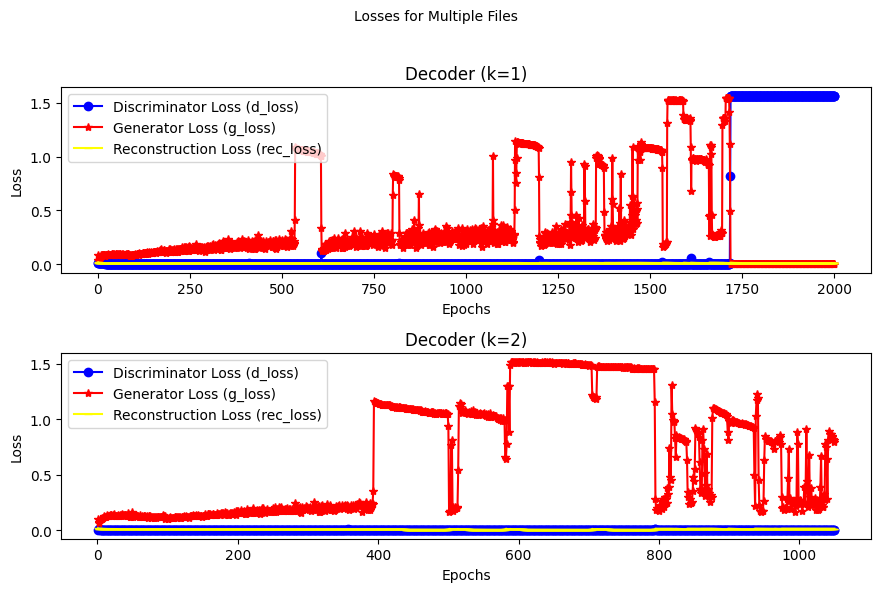

In [62]:
p1 = "/home/kawada-kuka/siddharth/ADRL/Losses/Decoder/loss_k1.txt"
t1 = "Decoder (k=1)"

p2 = "/home/kawada-kuka/siddharth/ADRL/Losses/Decoder/loss_k2.txt"
t2 = "Decoder (k=2)"

file_paths = [p1,p2]  
titles = [t1,t2]
plot_loss(file_paths, titles,"Losses for Multiple Files")

#### Q9 MLP

For this question, we kept a train, val, test split of 80%, 10% and 10% respectively.

In [18]:
dataset = AnimalsDataset(data_loc)

#Split the dataset into training , validation and test sets
n = len(dataset)
train_size = int(0.8 * n)
val_size = (n - train_size) // 2
test_size = n - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

For MLP classification, we used a simple linear layer followed by a softmax layer for 90 class classification. For the linear layer, the input dimension = 100 and hidden dimension = 200 with Relu activation.  

In [19]:
class MLP_classification(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=200, output_dim=91):
        super(MLP_classification, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.model(x)

The MLP classifier was trained with the following hyperparameters:  
epochs = 200  
batch size = 32   
learning rate = 0.0004  
  
The decoder was kept frozen during the training process. After every epoch, validation was performed on the validation set. 

In [24]:
def train_MLP_classifier(model, latent_model, train_dataset, val_dataset, num_epochs=40, batch_size=32, learning_rate=1e-4, device='cuda'):
    model = model.to(device)
    latent_model = latent_model.to(device)
    model.train()
    latent_model.eval()
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        num_train_data = 0
        model.train()  # Set the model to training mode
        
        # Training phase
        tqdm_train = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]")
        for batch in tqdm_train:
            images, labels = batch[0].to(device), batch[1].to(device)
            # print(images.device, labels.device)
            # Get latent space from the reverse GAN
            z = latent_model(images)
            # print("Device of z is", z.device)
            
            # Forward pass through classifier
            optimizer.zero_grad()
            output = model(z)
            loss = criterion(output, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track loss and accuracy
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()
            num_train_data += labels.size(0)
            
            # Update progress bar
            accuracy = (total_correct / num_train_data)
            tqdm_train.set_postfix(loss=total_loss / num_train_data, accuracy=accuracy)
        
        # Validation phase
        model.eval()  
        total_val_loss = 0
        total_correct_val = 0
        num_val_data = 0
        with torch.no_grad():  
            tqdm_val = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]")
            for batch in tqdm_val:
                images, labels = batch[0].to(device), batch[1].to(device)
                
                z = latent_model(images)
                
                output = model(z)
                loss = criterion(output, labels)
                
                total_val_loss += loss.item()
                total_correct_val += (output.argmax(1) == labels).sum().item()
                num_val_data += labels.size(0)
                
                accuracy_val = (total_correct_val / num_val_data) 
                tqdm_val.set_postfix(val_loss=total_val_loss / num_val_data, val_accuracy=accuracy_val)
        
        # Print statistics for the current epoch
        avg_train_loss = total_loss / num_train_data
        avg_val_loss = total_val_loss / num_val_data
        train_accuracy = (total_correct / num_train_data) * 100
        val_accuracy = (total_correct_val / num_val_data) * 100
        
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"    Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"    Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return model

In [22]:
def model_evaluation(model, latent_model, test_dataset, batch_size=16, device='cuda'):
    model = model.to(device)
    latent_model = latent_model.to(device)
    model.eval()
    latent_model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    total_correct = 0
    num_data = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        tqdm_test = tqdm(test_loader, desc="Testing")
        for batch in tqdm_test:
            images, labels = batch[0].to(device), batch[1].to(device)
            z = latent_model(images)
            output = model(z)
            
            # Collect predictions and true labels for F1-score
            preds = output.argmax(1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

            total_correct += (preds == labels).sum().item()
            num_data += labels.size(0)
            accuracy = (total_correct / num_data) * 100
            tqdm_test.set_postfix(accuracy=accuracy)
        
    # Calculate F1-score for the entire dataset (micro averaging)
    f1 = f1_score(all_labels, all_preds, average='micro')  

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test F1 Score (Micro): {f1:.2f}")

The latent model which we chose was the decoder model with the weights for k=1 at epoch 1801 as this model had minimum reconstruction loss during training . We had also trained models with different weights starting from epoch 1000 to epoch 2000 at intervals of 50 epochs, but this model had the best test accuracy. 

In [27]:
latent_model = Reverse_GAN()
latent_model.rev_gen = torch.load('/home/kawada-kuka/siddharth/ADRL/models/Decoder/epoch_1801/decoder.pth')
latent_model = latent_model.rev_gen
model = MLP_classification()

/tmp/ipykernel_23338/3824048065.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_model.rev_gen = torch.load('/home/kawada-kuka/siddharth/ADRL/models/Decoder/epoch_

In [ ]:
train_MLP_classifier(model, latent_model, train_dataset, val_dataset, num_epochs=200)

After training, we evaluated this model on the test dataset. Since this is a 90 class model, the expected guessing accuracy is 100/90 = 1.11%. Our model performs better than the guess accuracy at 7.04% with F1 score of 0.07. However, this accuracy is too low in terms of image classification standards. The possible reasons for this low accuracy is the unstable training of GAN along with the decoder. The decoder can create only as good of a representation of an image as the underlying Generator. If the generator itself is not able to capture the true data distribution (due to the large number of modes), then even if the decoder has perfect reconstruction, it won't encode the true latent representation of the images. 

In [29]:
model_evaluation(model, latent_model, test_dataset)

Testing: 100%|██████████| 68/68 [00:00<00:00, 125.14it/s, accuracy=7.04]

Test Accuracy: 7.04%
Test F1 Score (Micro): 0.07


#### Q10 Resnet on animal image dataset

In [42]:

class AnimalsDataset2(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
        self.data = []
        self.label_map = {}
        
        # Scan through each folder and prepare the data and labels
        for i, folder in enumerate(self.subfolders):
            for filename in os.listdir(folder):
                image_path = os.path.join(folder, filename)
                label_name = folder.split('/')[-1]  # Get folder name as label
                self.label_map[label_name] = i  # Assign label index for the folder
                self.data.append((image_path, i))  # Store image path and label index

        # Shuffle the data to randomize the order of images
        random.shuffle(self.data)

        # Define image transformations if not provided
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize(256),  # Resize image so shorter side is 256
            transforms.RandomResizedCrop(224),  # Crop random patch of size 224x224
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
            transforms.ToTensor(),  # Convert image to tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
        ])

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get image path and label
        img_path, label = self.data[idx]

        # Open the image using PIL and convert to RGB (to handle grayscale images)
        img = Image.open(img_path).convert("RGB")

        # Apply the defined transformations
        img = self.transform(img)

        # Convert label to tensor
        label = torch.tensor(label)
        return img, label


For training Resnet model, we again kept the same train, val, test split as the previous question. The images were normalized using transforms and resized to 224 as per the original Resnet implementation [5]

In [43]:
dataset = AnimalsDataset2(data_loc)
#Split the dataset into training , validation and test sets
n = len(dataset)
train_size = int(0.8 * n)
val_size = (n - train_size) // 2
test_size = n - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(len(train_dataset), len(val_dataset), len(test_dataset))

8640 1080 1080


In [34]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 91)

/home/kawada-kuka/anaconda3/envs/adrl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kawada-kuka/anaconda3/envs/adrl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/kawada-kuka/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:27<00:00, 3.74MB/s]


The hyperparameters are:  
epochs = 50 (Since Resnet converges fast)  
batch size = 32  
learning rate = 0.0001



In [45]:
def train_resnet(model, train_dataset, val_dataset, num_epochs=50, batch_size=16, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    for epoch in range(num_epochs):
        model.train()
        tqdm_train = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]")
        total_loss = 0
        total_correct = 0
        num_data = 0
        for batch in tqdm_train:
            images, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()
            num_data += labels.size(0)
            accuracy = (total_correct / num_data) * 100
            tqdm_train.set_postfix(loss=total_loss / num_data, accuracy=accuracy)
        total_val_loss = 0
        total_correct_val = 0
        num_val_data = 0
        model.eval()
        with torch.no_grad():
            tqdm_val = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]")
            for batch in tqdm_val:
                images, labels = batch[0].to(device), batch[1].to(device)
                output = model(images)
                loss = criterion(output, labels)
                total_val_loss += loss.item()
                total_correct_val += (output.argmax(1) == labels).sum().item()
                num_val_data += labels.size(0)
                accuracy_val = (total_correct_val / num_val_data) * 100
                tqdm_val.set_postfix(val_loss=total_val_loss / num_val_data, val_accuracy=accuracy_val)
        avg_train_loss = total_loss / num_data
        avg_val_loss = total_val_loss / num_val_data
        train_accuracy = (total_correct / num_data) * 100
        val_accuracy = (total_correct_val / num_val_data) * 100
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"    Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"    Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    return model

In [ ]:
model = train_resnet(model, train_dataset, val_dataset, num_epochs=50, batch_size=32)

In [47]:
def model_evaluation_resnet(model, test_dataset, batch_size=16, device='cuda'):
    model = model.to(device)
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    total_correct = 0
    num_data = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        tqdm_test = tqdm(test_loader, desc="Testing")
        for batch in tqdm_test:
            images, labels = batch[0].to(device), batch[1].to(device)
            output = model(images)
            preds = output.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_correct += (preds == labels).sum().item()
            num_data += labels.size(0)
            accuracy = (total_correct / num_data) * 100
            tqdm_test.set_postfix(accuracy=accuracy)
    f1 = f1_score(all_labels, all_preds, average='micro')
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test F1 Score (Micro): {f1:.2f}")

The test accuracy of classification by resnet is 89.54% with an F1 score of 0.90 which far outperforms our MLP model, since resnet is a very powerful image classification backbone 

In [49]:
model_evaluation_resnet(model, test_dataset)

Testing: 100%|██████████| 68/68 [00:02<00:00, 29.02it/s, accuracy=89.5]

Test Accuracy: 89.54%
Test F1 Score (Micro): 0.90


#### Q11 Resnet Classifier on C DCGAN

In [7]:
data_folder = "/home/kawada-kuka/siddharth/ADRL/data_CDCGAN"
dataset = AnimalsDataset(data_folder)

#Split the dataset into training , validation and test sets
n = len(dataset)
train_size = int(0.8 * n)
val_size = (n - train_size) // 2
test_size = n - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [9]:
dataset.label_map

{'chimpanzee': 0,
 'bear': 1,
 'cat': 2,
 'bat': 3,
 'donkey': 4,
 'coyote': 5,
 'antelope': 6,
 'boar': 7,
 'crab': 8,
 'badger': 9,
 'butterfly': 10,
 'bison': 11,
 'deer': 12,
 'beetle': 13,
 'cow': 14,
 'dog': 15,
 'caterpillar': 16,
 'cockroach': 17,
 'bee': 18,
 'crow': 19}

In [17]:
from torch.optim import lr_scheduler

def resnet_model(num_classes = 20):
    model = resnet18(pretrained = True)
    
    num_ft = model.fc.in_features
    model.fc = nn.Linear(num_ft, num_classes)
    
    return model

def train_resnet(model, lr, train_dataset, val_dataset, batch_size, num_epochs, save_folder, device = "cuda"):
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
    # scheduler = lr_scheduler.StepLR(optimizer, stepsize = 7, gamma = 0.1)
    
    os.makedirs(save_folder, exist_ok = True)
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        num_train_data = 0
        model.train()  # Set the model to training mode
        
        # Training phase
        tqdm_train = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]")
        for batch in tqdm_train:
            images, labels = batch[0].to(device), batch[1].to(device)
            
            # Forward pass through classifier
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track loss and accuracy
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()
            num_train_data += labels.size(0)
            
            # Update progress bar
            accuracy = (total_correct / num_train_data)
            tqdm_train.set_postfix(loss=total_loss / num_train_data, accuracy=accuracy)
        
        # Validation phase
        model.eval()  
        total_val_loss = 0
        total_correct_val = 0
        num_val_data = 0
        with torch.no_grad():  
            tqdm_val = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]")
            for batch in tqdm_val:
                images, labels = batch[0].to(device), batch[1].to(device)
                
                output = model(images)
                loss = criterion(output, labels)
                
                total_val_loss += loss.item()
                total_correct_val += (output.argmax(1) == labels).sum().item()
                num_val_data += labels.size(0)
                
                accuracy_val = (total_correct_val / num_val_data) 
                tqdm_val.set_postfix(val_loss=total_val_loss / num_val_data, val_accuracy=accuracy_val)
        
        # Print statistics for the current epoch
        avg_train_loss = total_loss / num_train_data
        avg_val_loss = total_val_loss / num_val_data
        train_accuracy = (total_correct / num_train_data) * 100
        val_accuracy = (total_correct_val / num_val_data) * 100
        
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"    Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"    Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return model
    
def model_evaluation(model, test_dataset, batch_size=16, device='cuda'):
    model = model.to(device)
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    total_correct = 0
    num_data = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        tqdm_test = tqdm(test_loader, desc="Testing")
        for batch in tqdm_test:
            images, labels = batch[0].to(device), batch[1].to(device)
            output = model(images)
            
            # Collect predictions and true labels for F1-score
            preds = output.argmax(1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

            total_correct += (preds == labels).sum().item()
            num_data += labels.size(0)
            accuracy = (total_correct / num_data) * 100
            tqdm_test.set_postfix(accuracy=accuracy)
        
    # Calculate F1-score for the entire dataset (micro averaging)
    f1 = f1_score(all_labels, all_preds, average='micro')  

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test F1 Score (Micro): {f1:.2f}")

In [ ]:
# Hyperparameters
lr = 0.001
batch_size = 32
epochs = 50
save_folder = "/home/kawada-kuka/siddharth/ADRL/models/resnet18"
model = resnet_model()

final_model = train_resnet(model, lr, train_dataset, val_dataset, batch_size, epochs, save_folder)
torch.save(final_model, os.path.join(save_folder, 'resnet18.pth'))


#### Results Interpretation

The ResNet classifier was trained on **real images** from the dataset and achieved the following results on the test set:

- **Accuracy:** 92.08%
- **Micro F1 Score:** 0.92

##### Interpretation

- **Training on Real Data:** The ResNet classifier was trained on the real image data from the dataset, and it achieved high performance on the test set. This indicates that the ResNet model effectively captured the underlying patterns and features present in the data, making it capable of classifying the images accurately.
  
- **High Accuracy and F1 Score:** Achieving 92.08% accuracy and a micro F1 score of 0.92 indicates that the classifier has strong generalization ability. The micro F1 score reflects balanced performance across all classes, which suggests that the model is performing well in both precision and recall across the dataset, and is not biased toward any specific class.
  
- **Model Generalization:** The ResNet classifier demonstrates that it can generalize well to unseen data, as evidenced by the high test accuracy. This means that the features learned during training on the real data are applicable to new examples, allowing the model to make accurate predictions on the test set.
  
- **Effectiveness of the ResNet Architecture:** The use of the ResNet architecture, which is known for its deep residual connections, has proven effective in learning complex representations of the data. The ResNet's ability to prevent vanishing gradients during training has likely contributed to its high accuracy and robust performance.
  
- **Potential Applications:** This high-performing classifier can be applied in various real-world tasks where classifying the given image data is essential. With an accuracy of 92.08% and an F1 score of 0.92, the model is well-suited for practical applications such as image recognition, object classification, and even automated systems requiring image-based decision making.

##### Conclusion

The ResNet classifier trained on real images has achieved excellent results, with an accuracy of 92.08% and a micro F1 score of 0.92. These results demonstrate that the ResNet model can effectively learn and generalize from the real image data, making it a reliable model for classifying images in this dataset. The high performance of the model indicates that the network is capturing relevant features from the dataset, leading to strong generalization on unseen data.


In [21]:
model_evaluation(final_model,test_dataset )

Testing: 100%|██████████| 15/15 [00:00<00:00, 94.73it/s, accuracy=92.1]

Test Accuracy: 92.08%
Test F1 Score (Micro): 0.92


#### Q12 Resnet Contd

In [40]:
# Reverse the label_map so we can map indices to class names
reverse_label_map = {v: k for k, v in label_map.items()}

def generate_images(generator, num_samples, z_dim, label, device):
    z = torch.randn(num_samples, z_dim).to(device)
    labels = torch.full((num_samples,), label, dtype=torch.long).to(device)
    with torch.no_grad():
        generated_images = generator(z, labels)
    return generated_images

def save_images(images, labels, output_dir, label_map):
    images = (images + 1) / 2  # Rescale images from [-1, 1] to [0, 1]

    for i in range(len(images)):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = (img * 255).astype('uint8')  # Convert to uint8 format for saving
        img_pil = Image.fromarray(img)

        class_name = reverse_label_map[labels[i].item()]
        class_dir = os.path.join(output_dir, class_name)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        img_filename = os.path.join(class_dir, f"{class_name}_{i}.png")
        img_pil.save(img_filename)

        print(f"Saved: {img_filename}")

# Parameters
num_samples_per_class = 100  
z_dim = 200                   
output_dir = "/home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy"  
device = "cpu"
c_gen = torch.load("/home/kawada-kuka/siddharth/ADRL/models/Conditional_DCGAN_k2/epoch_901/generator_best.pth").to("cpu")

# Generate and save images for each class
for class_name, label in label_map.items():
    print(f"Generating images for class: {class_name} (label {label})")
    generated_images = generate_images(c_gen, num_samples_per_class, z_dim, label, device)
    save_images(generated_images, torch.full((num_samples_per_class,), label), output_dir, label_map)

print("Image generation and saving complete.")


/tmp/ipykernel_8297/1662753790.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  c_gen = torch.load("/home/kawada-kuka/siddharth/ADRL/models/Conditional_DCGAN_k2/epoch_90

Generating images for class: chimpanzee (label 0)
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_0.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_1.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_2.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_3.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_4.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_5.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_6.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_7.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_8.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_9.png
Saved: /home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy/chimpanzee/chimpanzee_10.png
Saved: /home/k

In [41]:
data_folder = "/home/kawada-kuka/siddharth/ADRL/data_CDCGAN copy"
dataset = AnimalsDataset(data_folder)

#Split the dataset into training , validation and test sets
n = len(dataset)
train_size = int(0.8 * n)
val_size = (n - train_size) // 2
test_size = n - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [43]:
def resnet_model(num_classes = 20):
    model = resnet18(pretrained = True)
    
    num_ft = model.fc.in_features
    model.fc = nn.Linear(num_ft, num_classes)
    
    return model

def train_resnet(model, lr, train_dataset, val_dataset, batch_size, num_epochs, save_folder, device = "cuda"):
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
    # scheduler = lr_scheduler.StepLR(optimizer, stepsize = 7, gamma = 0.1)
    
    os.makedirs(save_folder, exist_ok = True)
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        num_train_data = 0
        model.train()  # Set the model to training mode
        
        # Training phase
        tqdm_train = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]")
        for batch in tqdm_train:
            images, labels = batch[0].to(device), batch[1].to(device)
            
            # Forward pass through classifier
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track loss and accuracy
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()
            num_train_data += labels.size(0)
            
            # Update progress bar
            accuracy = (total_correct / num_train_data)
            tqdm_train.set_postfix(loss=total_loss / num_train_data, accuracy=accuracy)
        
        # Validation phase
        model.eval()  
        total_val_loss = 0
        total_correct_val = 0
        num_val_data = 0
        with torch.no_grad():  
            tqdm_val = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]")
            for batch in tqdm_val:
                images, labels = batch[0].to(device), batch[1].to(device)
                
                output = model(images)
                loss = criterion(output, labels)
                
                total_val_loss += loss.item()
                total_correct_val += (output.argmax(1) == labels).sum().item()
                num_val_data += labels.size(0)
                
                accuracy_val = (total_correct_val / num_val_data) 
                tqdm_val.set_postfix(val_loss=total_val_loss / num_val_data, val_accuracy=accuracy_val)
        
        # Print statistics for the current epoch
        avg_train_loss = total_loss / num_train_data
        avg_val_loss = total_val_loss / num_val_data
        train_accuracy = (total_correct / num_train_data) * 100
        val_accuracy = (total_correct_val / num_val_data) * 100
        
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"    Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"    Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return model
    
def model_evaluation(model, test_dataset, batch_size=16, device='cuda'):
    model = model.to(device)
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    total_correct = 0
    num_data = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        tqdm_test = tqdm(test_loader, desc="Testing")
        for batch in tqdm_test:
            images, labels = batch[0].to(device), batch[1].to(device)
            output = model(images)
            
            # Collect predictions and true labels for F1-score
            preds = output.argmax(1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

            total_correct += (preds == labels).sum().item()
            num_data += labels.size(0)
            accuracy = (total_correct / num_data) * 100
            tqdm_test.set_postfix(accuracy=accuracy)
        
    # Calculate F1-score for the entire dataset (micro averaging)
    f1 = f1_score(all_labels, all_preds, average='micro')  

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test F1 Score (Micro): {f1:.2f}")

In [44]:
# Hyperparameters
lr = 0.001
batch_size = 32
epochs = 50
save_folder = "/home/kawada-kuka/siddharth/ADRL/models/resnet18"
model = resnet_model()

final_model = train_resnet(model, lr, train_dataset, val_dataset, batch_size, epochs, save_folder)
torch.save(final_model, os.path.join(save_folder, 'resnet18_new.pth'))


/home/kawada-kuka/anaconda3/envs/adrl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kawada-kuka/anaconda3/envs/adrl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 45.73it/s, val_accuracy=0.895, val_loss=0.0153]


Epoch 1/50:
    Train Loss: 0.0424, Train Accuracy: 65.45%
    Validation Loss: 0.0153, Validation Accuracy: 89.55%


Epoch 2/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.47it/s, val_accuracy=0.939, val_loss=0.00911]


Epoch 2/50:
    Train Loss: 0.0104, Train Accuracy: 93.66%
    Validation Loss: 0.0091, Validation Accuracy: 93.86%


Epoch 3/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.84it/s, val_accuracy=0.941, val_loss=0.00706]


Epoch 3/50:
    Train Loss: 0.0044, Train Accuracy: 98.44%
    Validation Loss: 0.0071, Validation Accuracy: 94.09%


Epoch 4/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.52it/s, val_accuracy=0.945, val_loss=0.00644]


Epoch 4/50:
    Train Loss: 0.0023, Train Accuracy: 99.52%
    Validation Loss: 0.0064, Validation Accuracy: 94.55%


Epoch 5/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.51it/s, val_accuracy=0.948, val_loss=0.00552]


Epoch 5/50:
    Train Loss: 0.0014, Train Accuracy: 99.86%
    Validation Loss: 0.0055, Validation Accuracy: 94.77%


Epoch 6/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.39it/s, val_accuracy=0.955, val_loss=0.00519]


Epoch 6/50:
    Train Loss: 0.0009, Train Accuracy: 100.00%
    Validation Loss: 0.0052, Validation Accuracy: 95.45%


Epoch 7/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.00it/s, val_accuracy=0.957, val_loss=0.00496]


Epoch 7/50:
    Train Loss: 0.0007, Train Accuracy: 99.97%
    Validation Loss: 0.0050, Validation Accuracy: 95.68%


Epoch 8/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.85it/s, val_accuracy=0.955, val_loss=0.00522]


Epoch 8/50:
    Train Loss: 0.0005, Train Accuracy: 100.00%
    Validation Loss: 0.0052, Validation Accuracy: 95.45%


Epoch 9/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.85it/s, val_accuracy=0.957, val_loss=0.00504]


Epoch 9/50:
    Train Loss: 0.0005, Train Accuracy: 100.00%
    Validation Loss: 0.0050, Validation Accuracy: 95.68%


Epoch 10/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.46it/s, val_accuracy=0.959, val_loss=0.00476]


Epoch 10/50:
    Train Loss: 0.0004, Train Accuracy: 100.00%
    Validation Loss: 0.0048, Validation Accuracy: 95.91%


Epoch 11/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.09it/s, val_accuracy=0.955, val_loss=0.00463]


Epoch 11/50:
    Train Loss: 0.0003, Train Accuracy: 100.00%
    Validation Loss: 0.0046, Validation Accuracy: 95.45%


Epoch 12/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 51.07it/s, val_accuracy=0.959, val_loss=0.00488]


Epoch 12/50:
    Train Loss: 0.0003, Train Accuracy: 100.00%
    Validation Loss: 0.0049, Validation Accuracy: 95.91%


Epoch 13/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.64it/s, val_accuracy=0.961, val_loss=0.00449]


Epoch 13/50:
    Train Loss: 0.0003, Train Accuracy: 100.00%
    Validation Loss: 0.0045, Validation Accuracy: 96.14%


Epoch 14/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.61it/s, val_accuracy=0.957, val_loss=0.00471]


Epoch 14/50:
    Train Loss: 0.0002, Train Accuracy: 100.00%
    Validation Loss: 0.0047, Validation Accuracy: 95.68%


Epoch 15/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.78it/s, val_accuracy=0.964, val_loss=0.00441]


Epoch 15/50:
    Train Loss: 0.0002, Train Accuracy: 100.00%
    Validation Loss: 0.0044, Validation Accuracy: 96.36%


Epoch 16/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 52.43it/s, val_accuracy=0.966, val_loss=0.00453]


Epoch 16/50:
    Train Loss: 0.0002, Train Accuracy: 100.00%
    Validation Loss: 0.0045, Validation Accuracy: 96.59%


Epoch 17/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.81it/s, val_accuracy=0.957, val_loss=0.00476]


Epoch 17/50:
    Train Loss: 0.0002, Train Accuracy: 100.00%
    Validation Loss: 0.0048, Validation Accuracy: 95.68%


Epoch 18/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.47it/s, val_accuracy=0.961, val_loss=0.00459]


Epoch 18/50:
    Train Loss: 0.0002, Train Accuracy: 100.00%
    Validation Loss: 0.0046, Validation Accuracy: 96.14%


Epoch 19/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.57it/s, val_accuracy=0.961, val_loss=0.00451]


Epoch 19/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0045, Validation Accuracy: 96.14%


Epoch 20/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.80it/s, val_accuracy=0.961, val_loss=0.00451]


Epoch 20/50:
    Train Loss: 0.0002, Train Accuracy: 100.00%
    Validation Loss: 0.0045, Validation Accuracy: 96.14%


Epoch 21/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.19it/s, val_accuracy=0.964, val_loss=0.00429]


Epoch 21/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.36%


Epoch 22/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.61it/s, val_accuracy=0.961, val_loss=0.00466]


Epoch 22/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0047, Validation Accuracy: 96.14%


Epoch 23/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.27it/s, val_accuracy=0.959, val_loss=0.00448]


Epoch 23/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0045, Validation Accuracy: 95.91%


Epoch 24/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.59it/s, val_accuracy=0.966, val_loss=0.00427]


Epoch 24/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.59%


Epoch 25/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.03it/s, val_accuracy=0.959, val_loss=0.00431]


Epoch 25/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 95.91%


Epoch 26/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.67it/s, val_accuracy=0.961, val_loss=0.00427]


Epoch 26/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.14%


Epoch 27/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.56it/s, val_accuracy=0.966, val_loss=0.00442]


Epoch 27/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0044, Validation Accuracy: 96.59%


Epoch 28/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.09it/s, val_accuracy=0.961, val_loss=0.0044] 


Epoch 28/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0044, Validation Accuracy: 96.14%


Epoch 29/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.68it/s, val_accuracy=0.961, val_loss=0.00429]


Epoch 29/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.14%


Epoch 30/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.22it/s, val_accuracy=0.957, val_loss=0.00439]


Epoch 30/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0044, Validation Accuracy: 95.68%


Epoch 31/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.96it/s, val_accuracy=0.961, val_loss=0.00428]


Epoch 31/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.14%


Epoch 32/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 44.91it/s, val_accuracy=0.955, val_loss=0.00449]


Epoch 32/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0045, Validation Accuracy: 95.45%


Epoch 33/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.57it/s, val_accuracy=0.955, val_loss=0.00457]


Epoch 33/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0046, Validation Accuracy: 95.45%


Epoch 34/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.88it/s, val_accuracy=0.959, val_loss=0.00458]


Epoch 34/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0046, Validation Accuracy: 95.91%


Epoch 35/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.80it/s, val_accuracy=0.964, val_loss=0.00415]


Epoch 35/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0042, Validation Accuracy: 96.36%


Epoch 36/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.65it/s, val_accuracy=0.961, val_loss=0.00445]


Epoch 36/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0044, Validation Accuracy: 96.14%


Epoch 37/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.16it/s, val_accuracy=0.964, val_loss=0.00432]


Epoch 37/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.36%


Epoch 38/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.98it/s, val_accuracy=0.964, val_loss=0.00433]


Epoch 38/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.36%


Epoch 39/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 47.14it/s, val_accuracy=0.968, val_loss=0.00427]


Epoch 39/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.82%


Epoch 40/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 51.26it/s, val_accuracy=0.964, val_loss=0.00438]


Epoch 40/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0044, Validation Accuracy: 96.36%


Epoch 41/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.43it/s, val_accuracy=0.959, val_loss=0.00452]


Epoch 41/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0045, Validation Accuracy: 95.91%


Epoch 42/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.68it/s, val_accuracy=0.959, val_loss=0.00414]


Epoch 42/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0041, Validation Accuracy: 95.91%


Epoch 43/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.30it/s, val_accuracy=0.964, val_loss=0.0042] 


Epoch 43/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0042, Validation Accuracy: 96.36%


Epoch 44/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.67it/s, val_accuracy=0.959, val_loss=0.00455]


Epoch 44/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0045, Validation Accuracy: 95.91%


Epoch 45/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.29it/s, val_accuracy=0.955, val_loss=0.00449]


Epoch 45/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0045, Validation Accuracy: 95.45%


Epoch 46/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.99it/s, val_accuracy=0.964, val_loss=0.00434]


Epoch 46/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.36%


Epoch 47/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 50.51it/s, val_accuracy=0.961, val_loss=0.0042] 


Epoch 47/50:
    Train Loss: 0.0000, Train Accuracy: 100.00%
    Validation Loss: 0.0042, Validation Accuracy: 96.14%


Epoch 48/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 49.27it/s, val_accuracy=0.961, val_loss=0.00435]


Epoch 48/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.14%


Epoch 49/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.31it/s, val_accuracy=0.968, val_loss=0.00422]


Epoch 49/50:
    Train Loss: 0.0000, Train Accuracy: 100.00%
    Validation Loss: 0.0042, Validation Accuracy: 96.82%


Epoch 50/50 [Validation]: 100%|██████████| 14/14 [00:00<00:00, 48.44it/s, val_accuracy=0.966, val_loss=0.00428]


Epoch 50/50:
    Train Loss: 0.0001, Train Accuracy: 100.00%
    Validation Loss: 0.0043, Validation Accuracy: 96.59%


##### Results After Retraining with Synthetic Data

After generating **100 synthetic samples per 20 class** using the **Conditional DCGAN** (CDC-GAN), the **ResNet classifier** was retrained for **50 epochs**. The results achieved during testing are as follows:

- **Test Accuracy:** 97.05%
- **Micro F1 Score:** 0.97

##### Interpretation of Results

##### Improvement in Accuracy and F1 Score

The **test accuracy** increased from **92.08%** to **97.05%**, and the **micro F1 score** improved from **0.92** to **0.97**. This significant improvement can be attributed to the following factors:

- **Augmented Data from CDCGAN:** By generating synthetic samples using the CDCGAN, the classifier was exposed to a larger and more diverse set of training examples. The synthetic data likely helped the model learn better representations of the features by providing additional training examples, especially in cases where the original dataset might have been limited or lacked diversity.
  
- **Better Generalization:** The increase in accuracy and F1 score suggests that the model has **improved generalization**. This means that the ResNet classifier has become better at recognizing patterns in both the real and synthetic images, improving its performance on unseen data. The synthetic samples enriched the dataset, allowing the model to generalize better to new examples.

- **Reduced Overfitting:** With the addition of synthetic data, the model was less likely to overfit the original training data. The larger and more diverse dataset helped the model avoid memorizing specific features of the real training set, which often leads to overfitting. This could explain the higher test accuracy and F1 score.

##### Significance of the Improvements

- **Enhanced Representation Learning:** By incorporating synthetic images generated by the CDCGAN, the model has been exposed to more varied instances of each class, thereby learning better feature representations. This improved learning leads to better decision boundaries and more accurate classification on both real and synthetic data.

- **Synthetic Data Augmentation:** The success of using synthetic data demonstrates the power of data augmentation techniques, particularly in cases where the real dataset might be small, imbalanced, or lacks sufficient diversity. By supplementing the real data with generated samples, the model is able to achieve higher performance, often seen in real-world applications where labeled data is scarce or expensive to acquire.

- **Improved F1 Score (Micro):** The micro F1 score improvement reflects a more balanced performance across all classes. The model is now better at handling both minority and majority classes, indicating that the generated samples have contributed to addressing class imbalance or difficulties faced by the original model.




In [45]:
model_evaluation(final_model,test_dataset)

Testing: 100%|██████████| 28/28 [00:00<00:00, 73.00it/s, accuracy=97]  

Test Accuracy: 97.05%
Test F1 Score (Micro): 0.97


##### Conclusion

The retraining of the ResNet classifier with 100 synthetic samples generated by the CDCGAN has led to a significant improvement in both **test accuracy (97.05%)** and **micro F1 score (0.97)**. This highlights the effectiveness of synthetic data augmentation in improving model performance, particularly in scenarios where real-world data may be limited or imbalanced. The results show that the model has become more robust, generalizing better to unseen data and achieving a well-balanced performance across all classes. This demonstrates that synthetic data, when generated effectively, can be a powerful tool for improving deep learning models in computer vision tasks.

#### References

###### [1] https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html?highlight=dcgan
###### [2] https://github.com/sobhanshukueian/Conditional-DCGAN
###### [3] Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). Generative adversarial nets. Advances in Neural Information Processing Systems, 27, 2672-2680.
###### [4] https://github.com/Ukyo317/WGAN-gp 
###### [5] He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep residual learning for image recognition." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 770-778. 2016.